<a href="https://colab.research.google.com/github/tec03/continuous_learning/blob/main/Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time Series Analysis - A road map


| Step                  | Goal                                       |
|-----------------------|--------------------------------------------|
| Decomposition         | Understand structure (trend, seasonality)  |
| Stationarity Testing  | Ensure ARIMA assumptions hold              |
| ACF/PACF              | Select ARIMA parameters (p, d, q)          |
| ARIMA Forecasting     | Predict future values                      |
| Evaluation            | Compare prediction to actual outcomes      |

###  Glossary

-   *time series*: A dataset where each value is associated with a specific time, often representing measurements taken at regular intervals.

-   *seasonal decomposition:* A method of splitting a time series into a long-term trend, a repeating seasonal component, and a residual component.

-   *training series:* Part of a time series used to fit a model.

-   *test series:* Part of a time series used to check the accuracy of predictions generated by a model.

-   *retrodiction:* A prediction for a value observed in the past, often used to test or validate a model.

-   *window*: A sequence of consecutive values in a time series, used to compute a moving average.

-   *moving average*: A time series computed by averaging values in overlapping windows to smooth fluctuations.

-   *serial correlation*: The correlation between successive elements of a time series.

-   *autocorrelation*: A correlation between a time series and a shifted or lagged version of itself.

-   *lag*: The size of the shift in a serial correlation or autocorrelation.

### Learning Objectives

- Understand the structure of time series data
- Decompose a time series into *trend*, *seasonality*, and *noise*
- Apply *stationarity tests* (ADF, KPSS)
- Visualize and interpret *ACF/PACF* plots
- Fit and evaluate an *ARIMA model*
- Forecast future values and assess accuracy


Here we explores methods to *analyze and forecast time series data*, using both *seasonal decomposition* and *ARIMA modeling*. The case study focuses on *monthly renewable electricity generation in the U.S. (2001–2024)*.



### 1. Introduction to Time Series

> A *time series* is a sequence of observations recorded over time at regular intervals.  
Examples: stock prices, electricity demand, rainfall.

Key idea: *Observations are not independent* — past values influence future values.



## 2. Dataset: U.S. Electricity Generation (2001–2024)

*Source:* U.S. Energy Information Administration  
*Variable:* Monthly renewable electricity generation (GWh)  
*Why this dataset?* It shows clear:
- Trend
- Seasonality
- Random variation (noise)



### 3. Trend Analysis

  ▫️ Long-Term Trend
  - Use moving averages to smooth the data (`rolling().mean()`)

▫️ Detrending
- Remove trend to expose seasonal + residual structure  
- Formula: `Detrended = Original - Trend`



### 4. Seasonal Decomposition

We assume:

$$\text{Observed} = \text{Trend} + \text{Seasonality} + \text{Noise}$$

#### ▫️ Seasonal Component
- Constructed from monthly averages across years
- Captures periodic yearly effects (e.g., summer peaks)

#### ▫️ Residuals & KDE
- Residual = Observed – Trend – Seasonality
- Kernel Density Estimate helps assess if residuals behave like white noise



### 5. Forecasting with Decomposition

#### ▫️ Forecasting from June 2019 (5 years forward)
- *Trend:* Extrapolated using linear regression  
- *Seasonality:* Repeated cyclic pattern  
- *Prediction = Trend + Seasonality*

#### ▫️ Evaluation
- Visual comparison to actuals (post-2019)
- Error metrics (e.g., MAE, RMSE)


### 6. Multiplicative Model

When seasonal effects *grow with trend*, use:

$$
\text{Observed} = \text{Trend} \times \text{Seasonality} \times \text{Noise}
$$

- Useful when data shows proportional seasonal swings  
- Implement with `seasonal_decompose(..., model='multiplicative')`

▫️ Variance Explained
- Quantifies how well decomposition reconstructs the original series  
- Higher = better model fit



### 7. Autoregression Concepts

▫️ Idea 1: The future resembles the past
- Use lag features to predict next value

▫️ Idea 2: Predict change, not value
- Differences often have lower variance

▫️ Idea 3: Residual modeling
- Fit a second regression on residuals to refine forecasts



### 8. Moving Averages

- Smooth the series to observe trend
- Reduce short-term noise
- Useful for visualization and pre-processing



### 9. Retrodiction (Backcasting)

- Predict past values based on earlier inputs  
  Useful when:
    - Some early data is missing
    - You have future context available



### 10. ARIMA Modeling

  *ARIMA = AutoRegressive Integrated Moving Average*

- *AR (p):* Past values  
- *I (d):* Differencing to make data stationary  
- *MA (q):* Past forecast errors

Use when decomposition is not sufficient or trend/seasonality are weak or complex.



### 11. Stationarity Testing

- A stationary series has *constant mean, variance, and autocorrelation* over time
- Required for ARIMA models

  Tests used:
    - Augmented Dickey-Fuller (ADF)
    - KPSS test



### 12. ACF & PACF

- *ACF (q):* Correlation with lagged values  
- *PACF (p):* Partial correlation, controlling for intermediate lags  
- Plots help decide ARIMA hyperparameters


Autocorrelation Function - ACF:

* Measures the correlation of the time series with *lagged versions of itself*.
* Helps identify *repeating patterns* or persistence over time.
* Used to select the *q* parameter in *ARIMA(p, d, q)* (Moving Average part).



Partial Autocorrelation Function - PACF:

* Measures the correlation between the time series and a lagged version of itself, *controlling for the effects of intermediate lags*.
* Helps determine the *direct relationship* between current and past values.
* Used to select the *p* parameter in *ARIMA(p, d, q)* (AutoRegressive part).

### 1. Introduction to Time Series

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
def style_ax(ax,
             title="",
             xlabel="",
             ylabel="",
             label_style=None,
             grid_style=None,
             legend_style=None,
             xticks=None,
             xtick_labels=None,
             xtick_style=None,
             yticks=None,
             ytick_labels=None,
             ytick_style=None
            ):

    if label_style is None:
        label_style = {'fontsize': 11}

    if grid_style is None:
        grid_style = {'linestyle': '--', 'alpha': 0.5}

    if legend_style is None:
        legend_style = {'loc': 'best', 'fontsize': 11}

    if xtick_style is None:
        xtick_style = {'fontsize': 10, 'rotation': 45}

    if ytick_style is None:
        ytick_style = {'fontsize': 10}

    # Title and labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, **label_style)
    ax.set_ylabel(ylabel, **label_style)

    # Tick locations and labels
    if xticks is not None:
        ax.set_xticks(xticks)

    if xtick_labels is not None:
        ax.set_xticklabels(xtick_labels)

    if yticks is not None:
        ax.set_yticks(yticks)

    if ytick_labels is not None:
        ax.set_yticklabels(ytick_labels)

    # Tick label styles
    plt.setp(ax.get_xticklabels(),
             **xtick_style
             )

    plt.setp(ax.get_yticklabels(),
             **ytick_style
             )

    # Grid and legend
    ax.grid(**grid_style)
    ax.legend(**legend_style)


In [3]:
def make_style(base, **overrides):
    style = base.copy()
    style.update(overrides)
    return style

# Base style used for most line plots
base_line_style = {
    'color': 'teal',
    'linewidth': 1,
    'linestyle': '-',
    'alpha': 0.6,
    'marker': 'o',
    'markersize': 3,
    'markerfacecolor': 'white',
    'markeredgecolor': 'black',
    'zorder': 3,
    'dash_capstyle': 'round',
    'drawstyle': 'default'
}

# Line style for actual data
line_options = make_style(base_line_style,
                          drawstyle='steps-mid'
                          )

# Line style for trend line
trend_options = make_style(
    base_line_style,
    color='coral',
    linewidth=2,
    linestyle='-.',
    markersize=4,
    drawstyle='steps-mid'
)

# Line style for predictions
pred_options = make_style(
    base_line_style,
    color='gray',
    linewidth=2,
    linestyle=':',
    drawstyle='steps-mid'
)

# Model trend fit line (e.g., quadratic trend)
model_options = {
    'color': 'gray',
    'alpha': 0.6,
    'linestyle': '--'
}


# Line color for temp  lines
temp_options = make_style(
    base_line_style,
    color='firebrick',
    linewidth=2,
    linestyle=':',
    drawstyle='steps-mid'
)

line_options_default = make_style(line_options,
                                  drawstyle='default'
                                  )
pred_options_default = make_style(pred_options,
                                  drawstyle='default'
                                  )

## 2. Dataset: U.S. Electricity Generation (2001–2024)

As an example of time-series data, we'll use a [dataset](https://www.eia.gov/electricity/data/browser/) from the U.S. Energy Information Administration -- it includes total electricity generation per month from renewable sources from 2001 to 2024.


### 2.1. Reading, Inspecting, and Understanding the Dataset

In [4]:
tec03_path = 'https://raw.githubusercontent.com/tec03/Datasets/refs/heads/main/datasets/'
file_name = tec03_path+"Net_generation_for_all_sectors.csv"
df = pd.read_csv(file_name, skiprows=4)
df.head(2)

description                   units   source key  \
0  Net generation for all sectors  thousand megawatthours          NaN   
1                   United States                     NaN  ELEC.GEN..M   

  Jan 2001 Feb 2001 Mar 2001 Apr 2001 May 2001 Jun 2001 Jul 2001  ...  \
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN  ...   
1      NaN      NaN      NaN      NaN      NaN      NaN      NaN  ...   

  Sep 2023 Oct 2023 Nov 2023 Dec 2023 Jan 2024 Feb 2024 Mar 2024 Apr 2024  \
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

  May 2024 Jun 2024  
0      NaN      NaN  
1      NaN      NaN  

[2 rows x 285 columns]

In [5]:
no_favs = ["units", "source key"]
df = df.drop(columns=no_favs).set_index("description")
df.head(2)

Jan 2001 Feb 2001 Mar 2001 Apr 2001 May 2001  \
description                                                                   
Net generation for all sectors      NaN      NaN      NaN      NaN      NaN   
United States                       NaN      NaN      NaN      NaN      NaN   

                               Jun 2001 Jul 2001 Aug 2001 Sep 2001 Oct 2001  \
description                                                                   
Net generation for all sectors      NaN      NaN      NaN      NaN      NaN   
United States                       NaN      NaN      NaN      NaN      NaN   

                                ... Sep 2023 Oct 2023 Nov 2023 Dec 2023  \
description                     ...                                       
Net generation for all sectors  ...      NaN      NaN      NaN      NaN   
United States                   ...      NaN      NaN      NaN      NaN   

                               Jan 2024 Feb 2024 Mar 2024 Apr 2024 May 2024  \
description                                                                   
Net generation for all sectors      NaN      NaN      NaN      NaN      NaN   
United States                       NaN      NaN      NaN      NaN      NaN   

                               Jun 2024  
description                              
Net generation for all sectors      NaN  
United States                       NaN  

[2 rows x 282 columns]

In [6]:
df.columns

Index(['Jan 2001', 'Feb 2001', 'Mar 2001', 'Apr 2001', 'May 2001', 'Jun 2001',
       'Jul 2001', 'Aug 2001', 'Sep 2001', 'Oct 2001',
       ...
       'Sep 2023', 'Oct 2023', 'Nov 2023', 'Dec 2023', 'Jan 2024', 'Feb 2024',
       'Mar 2024', 'Apr 2024', 'May 2024', 'Jun 2024'],
      dtype='object', length=282)

### 2.2. Managing Missing Values and Cleaning Anomalies

In [7]:
placeholders = ["--", "n/a", "N/A", "", " ", "null", "None"]
sum = 0
for col in df.columns:
    missing_yes = df[col].isin(placeholders)
    temp_sum = df[col][missing_yes].value_counts().sum()
    sum += temp_sum
    # print(f"\nColumn: {col}\t :", temp_sum)
print(f"\nTotal missing values: {sum.sum()}")


Total missing values: 156


In [8]:
df.isnull().sum(axis=1)

description
Net generation for all sectors                    282
United States                                     282
United States : all fuels (utility-scale)         282
United States : nuclear                             0
United States : conventional hydroelectric          0
United States : other renewables                  282
United States : wind                                0
United States : all utility-scale solar             0
United States : geothermal                          0
United States : biomass                             0
United States : hydro-electric pumped storage       0
United States : all solar                         282
United States : small-scale solar photovoltaic      0
dtype: int64

In [9]:
df = df.replace(placeholders, np.nan)
df.head(2)

Jan 2001 Feb 2001 Mar 2001 Apr 2001 May 2001  \
description                                                                   
Net generation for all sectors      NaN      NaN      NaN      NaN      NaN   
United States                       NaN      NaN      NaN      NaN      NaN   

                               Jun 2001 Jul 2001 Aug 2001 Sep 2001 Oct 2001  \
description                                                                   
Net generation for all sectors      NaN      NaN      NaN      NaN      NaN   
United States                       NaN      NaN      NaN      NaN      NaN   

                                ... Sep 2023 Oct 2023 Nov 2023 Dec 2023  \
description                     ...                                       
Net generation for all sectors  ...      NaN      NaN      NaN      NaN   
United States                   ...      NaN      NaN      NaN      NaN   

                               Jan 2024 Feb 2024 Mar 2024 Apr 2024 May 2024  \
description                                                                   
Net generation for all sectors      NaN      NaN      NaN      NaN      NaN   
United States                       NaN      NaN      NaN      NaN      NaN   

                               Jun 2024  
description                              
Net generation for all sectors      NaN  
United States                       NaN  

[2 rows x 282 columns]

In [10]:
df.shape

(13, 282)

In [11]:
df.isnull().sum(axis=1)

description
Net generation for all sectors                    282
United States                                     282
United States : all fuels (utility-scale)         282
United States : nuclear                             0
United States : conventional hydroelectric          0
United States : other renewables                  282
United States : wind                                0
United States : all utility-scale solar             0
United States : geothermal                          0
United States : biomass                             0
United States : hydro-electric pumped storage       0
United States : all solar                         282
United States : small-scale solar photovoltaic    156
dtype: int64

In [12]:
thrsh_value = int(df.shape[1]*0.4) # we set, we need at least 40% the cells should have value. else we will drop
thrsh_value

112

In [13]:
df.dropna(inplace=True, thresh=thrsh_value)
df.shape

(8, 282)

After loading the data, we have to make some transformations to get it into a format that's easy to work with.

In [14]:
df = df.transpose().astype(float)
df.head(2)

description  United States : nuclear  \
Jan 2001                     68707.0   
Feb 2001                     61272.0   

description  United States : conventional hydroelectric  United States : wind  \
Jan 2001                                        18852.0                 389.0   
Feb 2001                                        17473.0                 431.0   

description  United States : all utility-scale solar  \
Jan 2001                                         7.0   
Feb 2001                                        13.0   

description  United States : geothermal  United States : biomass  \
Jan 2001                         1229.0                   4400.0   
Feb 2001                         1073.0                   3793.0   

description  United States : hydro-electric pumped storage  \
Jan 2001                                            -589.0   
Feb 2001                                            -707.0   

description  United States : small-scale solar photovoltaic  
Jan 2001                                                NaN  
Feb 2001                                                NaN

In [15]:
df.shape

(282, 8)

### 2.3. Clean and Set the Proper Index

The labels in the index are strings indicating months and years -- here are the first 12.

In [16]:
df.index

Index(['Jan 2001', 'Feb 2001', 'Mar 2001', 'Apr 2001', 'May 2001', 'Jun 2001',
       'Jul 2001', 'Aug 2001', 'Sep 2001', 'Oct 2001',
       ...
       'Sep 2023', 'Oct 2023', 'Nov 2023', 'Dec 2023', 'Jan 2024', 'Feb 2024',
       'Mar 2024', 'Apr 2024', 'May 2024', 'Jun 2024'],
      dtype='object', length=282)

In [17]:
df.index[:12]

Index(['Jan 2001', 'Feb 2001', 'Mar 2001', 'Apr 2001', 'May 2001', 'Jun 2001',
       'Jul 2001', 'Aug 2001', 'Sep 2001', 'Oct 2001', 'Nov 2001', 'Dec 2001'],
      dtype='object')

It will be easier to work with this data if we replace these strings with Pandas `Timestamp` objects.

  - We can use the `date_range` function to generate a sequence of `Timestamp` objects, starting in January 2001.
    -  frequency code `"ME"`, which stands for "month end", so it fills in the last day of each month.

In [18]:
type(df.index)

pandas.core.indexes.base.Index

In [19]:
df.index = pd.date_range(start = "2001-01",
                         periods = len(df),
                         freq = "ME" # month end
                         )
df.index[:6]

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30'],
              dtype='datetime64[ns]', freq='ME')

In [20]:
type(df.index.dtype)

numpy.dtypes.DateTime64DType

Now the index is a `DataTimeIndex` with the data type `datetime64[ns]`, which is defined in NumPy -- `64` means each label uses 64 bits, and `ns` means it has nanosecond precision.

In [21]:
df.tail(2)

description  United States : nuclear  \
2024-05-31                   64973.0   
2024-06-30                   68192.0   

description  United States : conventional hydroelectric  United States : wind  \
2024-05-31                                      21963.0               38936.0   
2024-06-30                                      21207.0               38330.0   

description  United States : all utility-scale solar  \
2024-05-31                                   22050.0   
2024-06-30                                   23918.0   

description  United States : geothermal  United States : biomass  \
2024-05-31                       1225.0                   3965.0   
2024-06-30                       1246.0                   3891.0   

description  United States : hydro-electric pumped storage  \
2024-05-31                                          -292.0   
2024-06-30                                          -586.0   

description  United States : small-scale solar photovoltaic  
2024-05-31                                           8592.0  
2024-06-30                                           8618.0

### 2.4. Fix Column Names: Short, Clean, and Code-Friendly

In the reformatted dataset, each column is a sequence of monthly totals in gigawatt-hours (GWh).
Here are the column labels, showing the different sources of electricity, or "sectors".

In [22]:
df.head(2)

description  United States : nuclear  \
2001-01-31                   68707.0   
2001-02-28                   61272.0   

description  United States : conventional hydroelectric  United States : wind  \
2001-01-31                                      18852.0                 389.0   
2001-02-28                                      17473.0                 431.0   

description  United States : all utility-scale solar  \
2001-01-31                                       7.0   
2001-02-28                                      13.0   

description  United States : geothermal  United States : biomass  \
2001-01-31                       1229.0                   4400.0   
2001-02-28                       1073.0                   3793.0   

description  United States : hydro-electric pumped storage  \
2001-01-31                                          -589.0   
2001-02-28                                          -707.0   

description  United States : small-scale solar photovoltaic  
2001-01-31                                              NaN  
2001-02-28                                              NaN

In [23]:
df.columns = [
  'nuclear',
  'hydroelectric',
  'wind',
  'utility_solar',
  'geothermal',
  'biomass',
  'pumped_storage',
  'small_solar'
]
df.tail(2)


nuclear  hydroelectric     wind  utility_solar  geothermal  \
2024-05-31  64973.0        21963.0  38936.0        22050.0      1225.0   
2024-06-30  68192.0        21207.0  38330.0        23918.0      1246.0   

            biomass  pumped_storage  small_solar  
2024-05-31   3965.0          -292.0       8592.0  
2024-06-30   3891.0          -586.0       8618.0

## 3. Trend Analysis

#### 3.1.1. Long-Term Trend

> Extract and visualize the smoothed long-term component using rolling averages or decomposition.

  - Use moving averages to smooth the data (`rolling().mean()`)

#### 3.1.2. Detrending

> Subtract trend to isolate seasonality and irregularities.

- Remove trend to expose seasonal + residual structure  
- Formula: `Detrended = Original - Trend`

#### 3.1.3. Seasonal Pattern (Monthly Averages)

> Group by month and compute average deviations to build the seasonal component.

#### 3.1.4. Expected Series

> Compute:
>
> $$
> \text{Expected}_t = \text{Trend}_t + \text{Seasonal}_t
> $$

> Plot expected vs. actual to validate fit.

#### 3.1.5. Residual Analysis

> Residuals = Observed − Expected

> Analyze distribution, autocorrelation, etc.

### 3.1.  How electricity generation from nuclear reactors changed over the interval from January 2001 to June 2024?

 - Study by decomposing the time series into a long-term trend and a periodic component.

Here are monthly totals of electricity generation from nuclear reactors in the United States.

In [24]:
nuclear_data = df['nuclear']

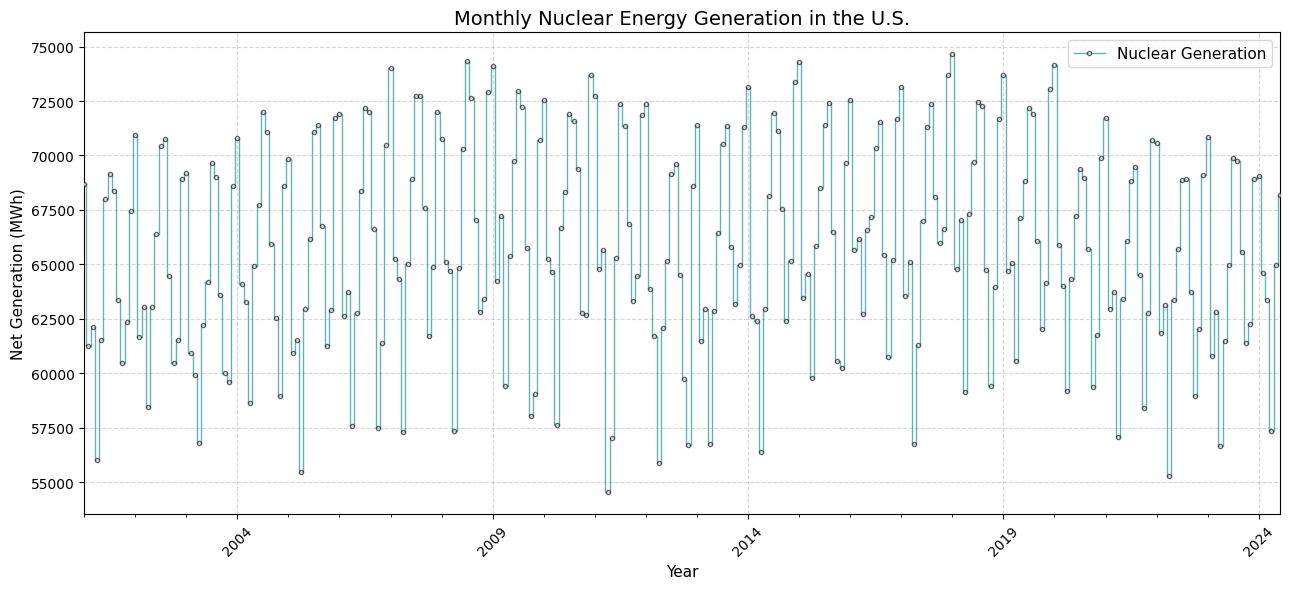

In [25]:
fig, ax = plt.subplots(figsize=(13, 6))

nuclear_data.plot(ax = ax,
                   label = 'Nuclear Generation',
                   **line_options,
                   )

style_ax(ax,
         title="Monthly Nuclear Energy Generation in the U.S.",
         xlabel="Year",
         ylabel="Net Generation (MWh)"
         )

plt.tight_layout()
plt.show()

Observartions:
  - It looks like there are some increases and decreases
    -  they are hard to see clearly because there are large variations from month to month.


#### 3.1.1. Long-term trend ?

To see the long-term trend more clearly, we can use the `rolling` and `mean` methods to compute a *moving average*.

In [26]:
df.tail(2)

nuclear  hydroelectric     wind  utility_solar  geothermal  \
2024-05-31  64973.0        21963.0  38936.0        22050.0      1225.0   
2024-06-30  68192.0        21207.0  38330.0        23918.0      1246.0   

            biomass  pumped_storage  small_solar  
2024-05-31   3965.0          -292.0       8592.0  
2024-06-30   3891.0          -586.0       8618.0

In [27]:
subset0 = nuclear_data[:12]
subset1 = nuclear_data[1:13]
subset2 = nuclear_data[2:14]
print(f"Length: {len(subset0)}\tMean: {subset0.mean():.2f}")
print(f"Length: {len(subset1)}\tMean: {subset1.mean():.2f}")
print(f"Length: {len(subset2)}\tMean: {subset2.mean():.2f}")

Length: 12	Mean: 64068.75
Length: 12	Mean: 64253.67
Length: 12	Mean: 64285.83


In [28]:
trend = nuclear_data.rolling(window=12).mean()
trend.head(15)

2001-01-31             NaN
2001-02-28             NaN
2001-03-31             NaN
2001-04-30             NaN
2001-05-31             NaN
2001-06-30             NaN
2001-07-31             NaN
2001-08-31             NaN
2001-09-30             NaN
2001-10-31             NaN
2001-11-30             NaN
2001-12-31    64068.750000
2002-01-31    64253.666667
2002-02-28    64285.833333
2002-03-31    64360.833333
Freq: ME, Name: nuclear, dtype: float64

The `window=12` argument selects overlapping intervals of 12 months.
  - the first interval contains 12 measurements starting with the first,
  - the second interval contains 12 measurements starting with the second,
  - and so on.

For each interval, we compute the mean production.

Here's what the results look like, along with the original data.

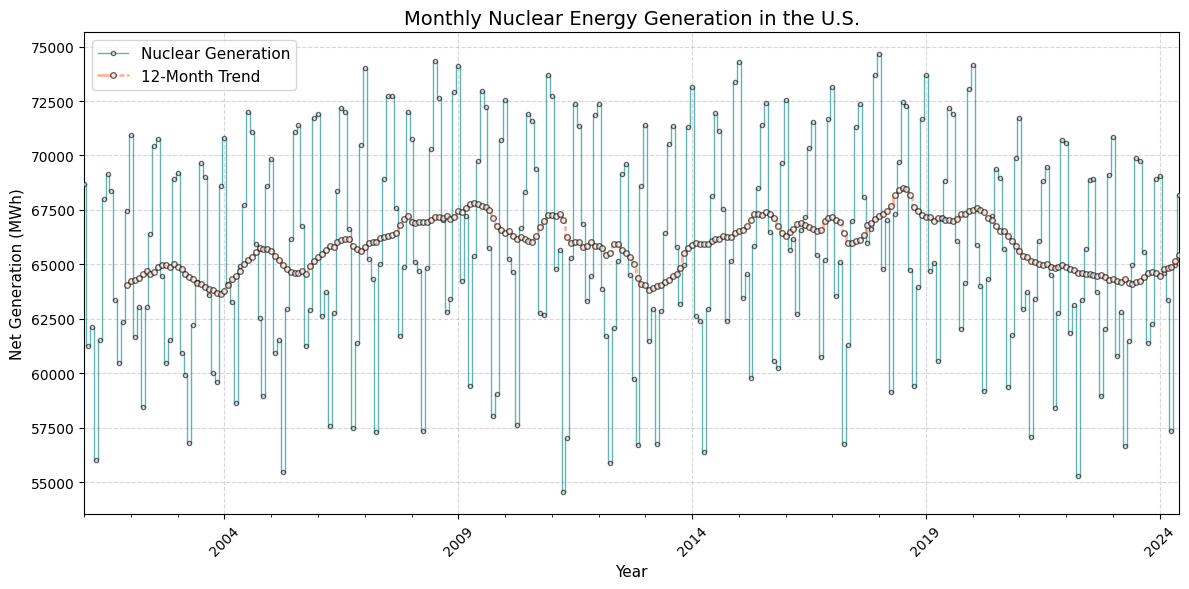

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))

nuclear_data.plot(ax=ax,
                  label="Nuclear Generation",
                  **line_options
                  )

trend.plot(ax=ax,
           label='12-Month Trend',
           **trend_options
           )

style_ax(ax,
         title="Monthly Nuclear Energy Generation in the U.S.",
         xlabel="Year",
         ylabel="Net Generation (MWh)"
         )

plt.tight_layout()
plt.show()


Observations:
  - The trend is still quite variable.
  - We could smooth it more by using a longer window
    - but we'll stick with the 12-month window for now.


#### 3.1.2. Detrending


If we *subtract the trend from the original data*, the result is a "detrended" time series, which means that the long-term mean is close to constant.


> Detrending is a powerful technique in time series analysis.  
> Detrending helps achieve *stationarity* - which is a key assumption for many forecasting models.



*What does detrending mean?*

  - Detrending means *removing the long-term trend* from a time series.

*Why do we detrend a time series?*

  1. To analyze short-term fluctuations.
      - Removing the trend lets you study the *underlying variations* or *cycles* more clearly - like seasonality, shocks, or random noise.
      - Removing the long-term growth in electricity generation lets you study *monthly or yearly volatility* due to policy or weather.

  2. To stabilize the mean (stationarity)
      - Many statistical models (like ARIMA, VAR) require the time series to have *constant mean and variance* over time.

  3. To compare components across time
      - In a multivariate setting (e.g. nuclear, solar, wind), detrending lets you see which energy source has *relative variation*, independent of overall growth.

  4. To isolate noise or irregular patterns.
      - You can remove the trend to focus on *anomalies*, *events*, or *unexpected changes*.
        - Eg. A sudden drop after removing the trend might point to *disruptions* (like a shutdown or disaster).

In [30]:
detrended = (nuclear_data - trend)
detrended[:15]

2001-01-31            NaN
2001-02-28            NaN
2001-03-31            NaN
2001-04-30            NaN
2001-05-31            NaN
2001-06-30            NaN
2001-07-31            NaN
2001-08-31            NaN
2001-09-30            NaN
2001-10-31            NaN
2001-11-30            NaN
2001-12-31    3362.250000
2002-01-31    6672.333333
2002-02-28   -2627.833333
2002-03-31   -1319.833333
Freq: ME, Name: nuclear, dtype: float64

In [31]:
detrended = detrended.dropna()
detrended[:2]

2001-12-31    3362.250000
2002-01-31    6672.333333
Freq: ME, Name: nuclear, dtype: float64

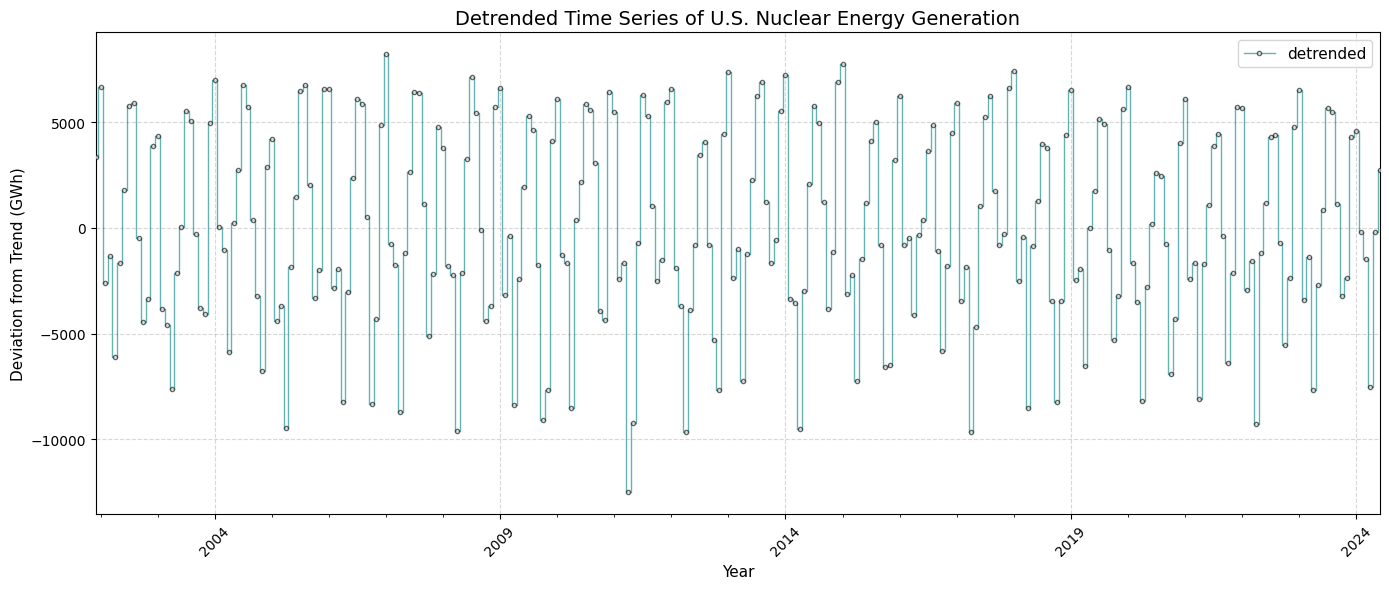

In [32]:
fig, ax = plt.subplots(figsize=(14, 6))

detrended.plot(label="detrended",
               **line_options
               )

style_ax(ax,
         title="Detrended Time Series of U.S. Nuclear Energy Generation",
         xlabel="Year",
         ylabel="Deviation from Trend (GWh)"
         )

plt.tight_layout()
plt.show()

Observations:

- It seems like there is a repeating annual pattern
  -  which makes sense because demand for electricity varies from one season to another
  -  it is used to generate heat in the winter and run air conditioning in the summer.

To describe this annual pattern we can select the month part of the `datetime` objects in the index, group the data by month, and compute average production.

#### 3.1.3. Seasonal Patterns

To describe annual seasonality, we extract the month from the datetime index and group the data by month. This gives a clear picture of the recurring seasonal structure in electricity generation.

The bar chart below displays the average production per calendar month across all years. Peaks and troughs indicate strong seasonal effects that will be useful in decomposition and forecasting.


Here's what the monthly averages look like:

In [33]:
df.tail(2)

nuclear  hydroelectric     wind  utility_solar  geothermal  \
2024-05-31  64973.0        21963.0  38936.0        22050.0      1225.0   
2024-06-30  68192.0        21207.0  38330.0        23918.0      1246.0   

            biomass  pumped_storage  small_solar  
2024-05-31   3965.0          -292.0       8592.0  
2024-06-30   3891.0          -586.0       8618.0

In [34]:
month_ids = detrended.index.month
month_ids

Index([12,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       ...
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6],
      dtype='int32', length=271)

In [35]:
monthly_averages = detrended.groupby(month_ids).mean().round(2)
monthly_averages

1     6254.26
2    -2338.66
3    -1953.63
4    -8195.73
5    -2043.49
6     1434.60
7     5264.65
8     5196.42
9       83.52
10   -4902.68
11   -3443.91
12    4951.35
Name: nuclear, dtype: float64


> Since `monthly_averages` is calculated as the mean of the `detrended` series grouped by month, the Y-axis represents the `average deviation from the trend` for each month.

In [36]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

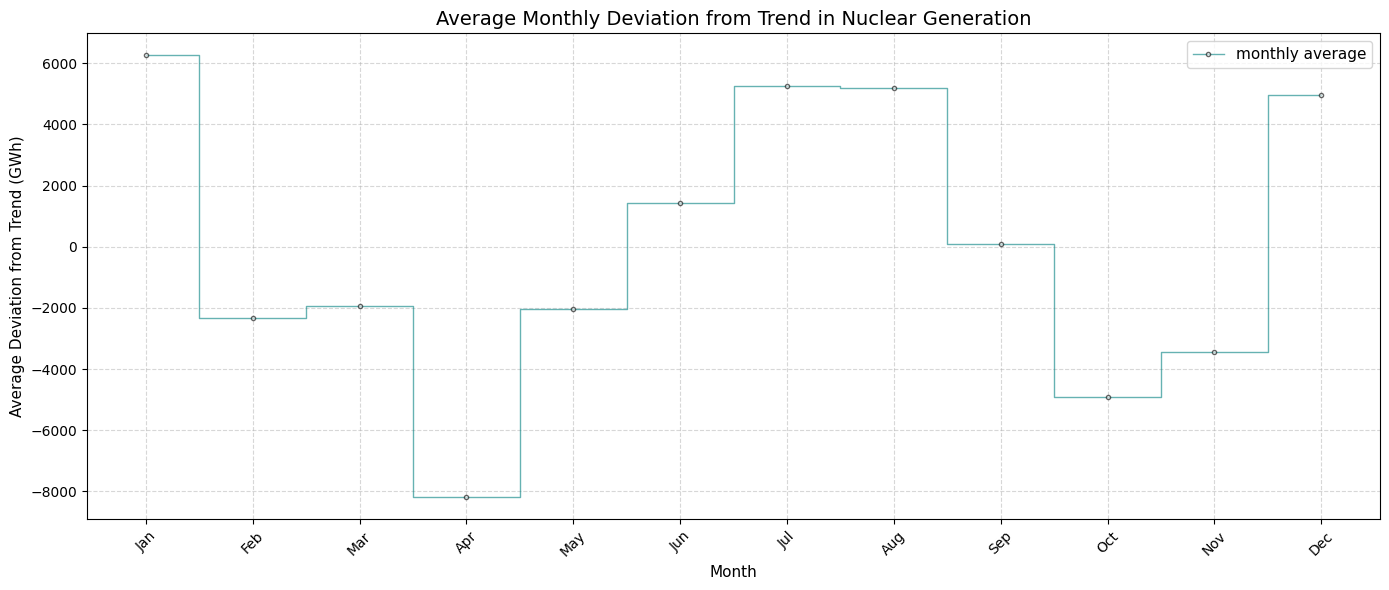

In [37]:
fig, ax = plt.subplots(figsize=(14, 6))

monthly_averages.plot(label="monthly average",
               **line_options
               )

style_ax(ax,
         title="Average Monthly Deviation from Trend in Nuclear Generation",
         xlabel="Month",
         ylabel="Average Deviation from Trend (GWh)",
         xticks=range(1, 13),
         xtick_labels=month_names,
         )


plt.tight_layout()
plt.show()

Observations:

- Electricity production is highest during the coldest and warmest months.
- Electricity production is lowest during April and October.

Why this `detrended` data is important ?

- Lets compare `detrended` vs `nuclear`.

In [38]:
month_ids_nuclear = nuclear_data.index.month
monthly_averages_nuclear = nuclear_data.groupby(month_ids_nuclear).mean().round(2)

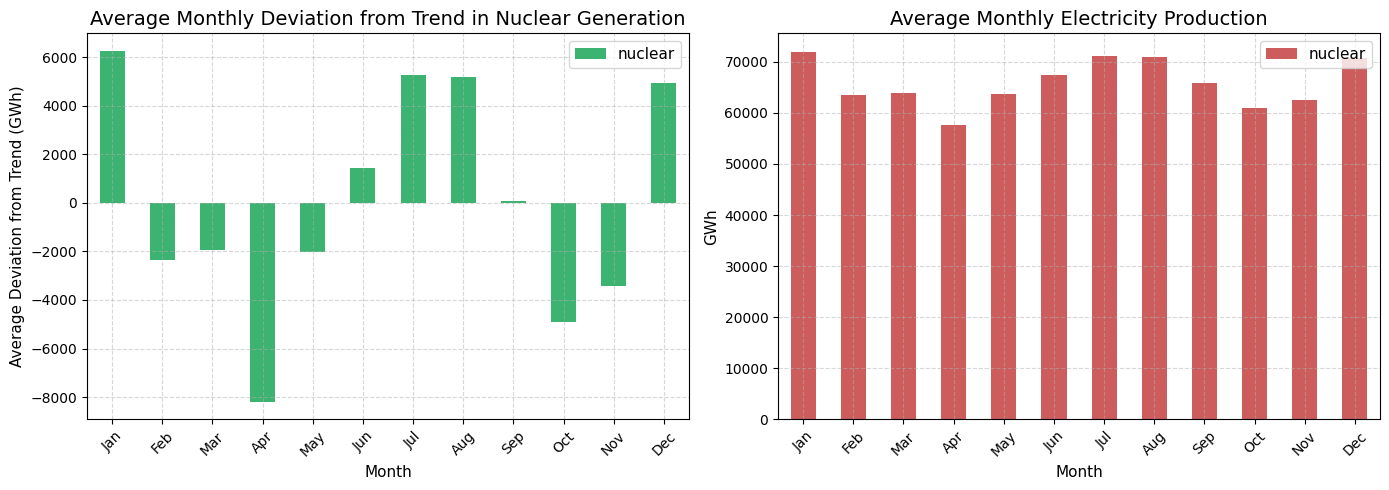

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

monthly_averages.plot(kind='bar', ax=axs[0], color='mediumseagreen')
monthly_averages_nuclear.plot(kind='bar', ax=axs[1], color='indianred')

style_ax(axs[1],
         title="Average Monthly Electricity Production",
         xlabel="Month",
         ylabel="GWh",
         xtick_labels=month_names,
         )


style_ax(axs[0],
         title="Average Monthly Deviation from Trend in Nuclear Generation",
         xlabel="Month",
         ylabel="Average Deviation from Trend (GWh)",
         xtick_labels=month_names,
         )

plt.tight_layout()
plt.show()


Observations:
  - Electricity production is highest during the coldest and warmest months.
  - Electricity production is lowest during April and October.


#### 3.1.4. The expected value for each month = The trend + The seasonal component.

Compute:
$$ Expected_t=Trend_t+Seasonal_t$$

$Seasonal\ component:$

We can use `monthly_averages` to $construct$ the seasonal component of the data
  - which is a series the same length as `nuclear`,
  - where the element for each month is the average for that month.

Here's what it looks like.

In [40]:
print(monthly_averages)
print(nuclear_data.index.month)
print(f'\nCopy this {len(monthly_averages)} month data to the remaining {len(nuclear_data.index.month)} months. To get Expected seasonal component.')

1     6254.26
2    -2338.66
3    -1953.63
4    -8195.73
5    -2043.49
6     1434.60
7     5264.65
8     5196.42
9       83.52
10   -4902.68
11   -3443.91
12    4951.35
Name: nuclear, dtype: float64
Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6],
      dtype='int32', length=282)

Copy this 12 month data to the remaining 282 months. To get Expected seasonal component.


In [41]:
seasonal = monthly_averages[nuclear_data.index.month] # by this Each 12-month period (year) is identical to the others (years).
seasonal

1    6254.26
2   -2338.66
3   -1953.63
4   -8195.73
5   -2043.49
      ...   
2   -2338.66
3   -1953.63
4   -8195.73
5   -2043.49
6    1434.60
Name: nuclear, Length: 282, dtype: float64

In [42]:
seasonal.index = nuclear_data.index
seasonal

2001-01-31    6254.26
2001-02-28   -2338.66
2001-03-31   -1953.63
2001-04-30   -8195.73
2001-05-31   -2043.49
               ...   
2024-02-29   -2338.66
2024-03-31   -1953.63
2024-04-30   -8195.73
2024-05-31   -2043.49
2024-06-30    1434.60
Freq: ME, Name: nuclear, Length: 282, dtype: float64

In [43]:
type(seasonal).__name__

'Series'

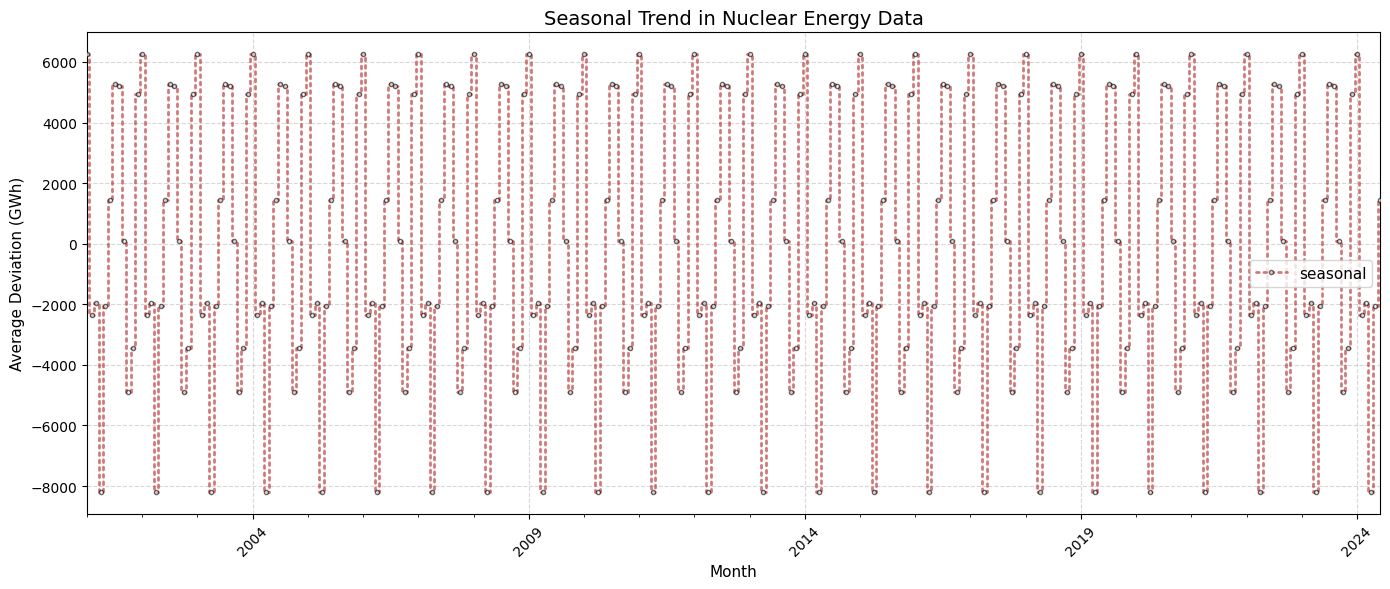

In [44]:
fig, ax = plt.subplots(figsize=(14, 6))

seasonal.plot(label="seasonal",
               **temp_options
               )

style_ax(ax,
         title="Seasonal Trend in Nuclear Energy Data",
         xlabel="Month",
         ylabel="Average Deviation (GWh)",
         )


plt.tight_layout()
plt.show()

Observation:
  - Each 12-month period is identical to the others.
    - We created so - the seasonal component.

The expected value for each month = The trend  +  The seasonal component.

In [45]:
print('type of TREND is \t: ', type(trend).__name__, '\t\tlenghth of TREND is \t:', len(trend))
print('type of SEASONAL is \t: ', type(seasonal).__name__, '\t\tlenghth of SEASONAL is \t:', len(seasonal))

print('\nIndex of TREND is \t: ', trend.index)
trend.index.equals(seasonal.index) #' == ' returns a vector of booleans; .equals() checks entire equality.

type of TREND is 	:  Series 		lenghth of TREND is 	: 282
type of SEASONAL is 	:  Series 		lenghth of SEASONAL is 	: 282

Index of TREND is 	:  DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31',
               '2001-09-30', '2001-10-31',
               ...
               '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31',
               '2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30',
               '2024-05-31', '2024-06-30'],
              dtype='datetime64[ns]', length=282, freq='ME')


True

In [46]:
expected = trend + seasonal
expected

2001-01-31             NaN
2001-02-28             NaN
2001-03-31             NaN
2001-04-30             NaN
2001-05-31             NaN
                  ...     
2024-02-29    62439.256667
2024-03-31    62868.120000
2024-04-30    56681.353333
2024-05-31    63125.260000
2024-06-30    66872.266667
Freq: ME, Name: nuclear, Length: 282, dtype: float64

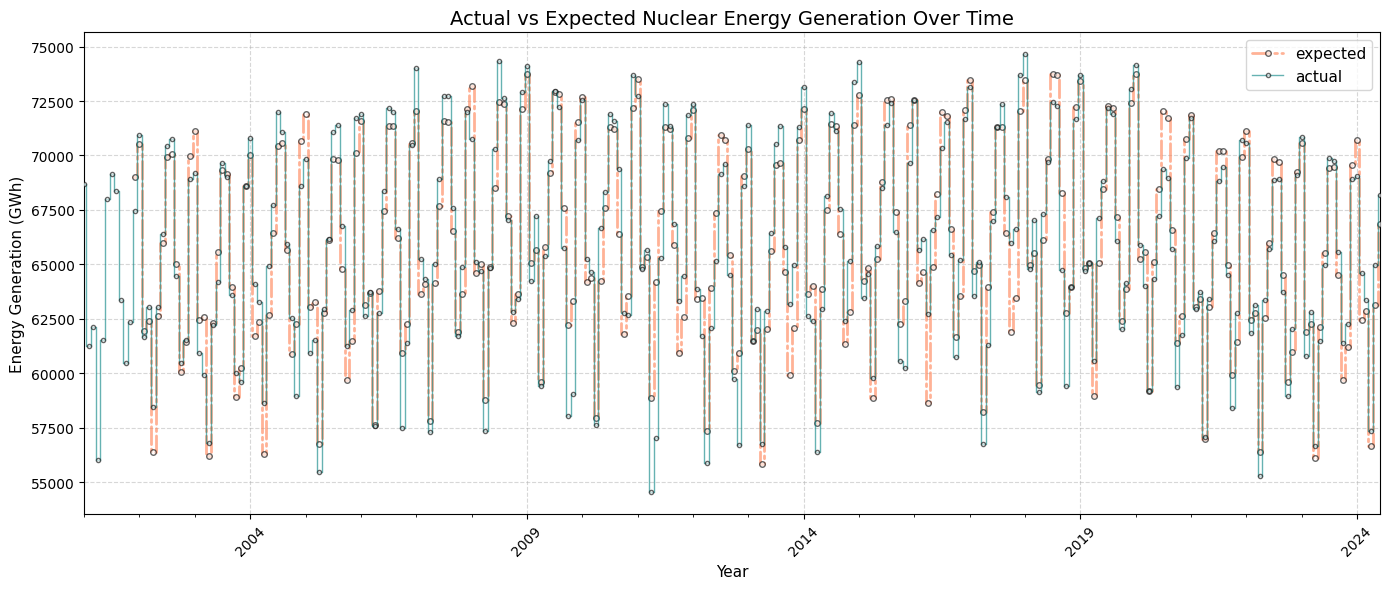

In [47]:
fig, ax = plt.subplots(figsize=(14, 6))

expected.plot(label="expected",
               **trend_options,
               )

nuclear_data.plot(label="actual",
               **line_options
               )


style_ax(ax,
         title="Actual vs Expected Nuclear Energy Generation Over Time",
         xlabel="Year",
         ylabel="Energy Generation (GWh)",
         )


plt.tight_layout()
plt.show()

Observations:
  - the `expected` and `actual` curves follow similar shapes year over year.
  - amplitude differences are present in some periods, where actual values deviate more than expected.
  - sharp drops or spikes in actual data are not matched by the expected model
    - indicating irregularities or external shocks.

#### 3.1.5. Residual Analysis


The *residual* is defined as the *difference between the actual data and the expected (trend or seasonal) component*:

$$
\text{Residual}_t = \text{Actual}_t - \text{Expected}_t
$$



Use of Residuals:

* Helps identify *anomalies or outliers*
* Useful for *model diagnostics*
* Can be plotted to see whether residuals are randomly distributed (good) or show patterns (bad model fit)

In [48]:
resid = nuclear_data - expected
resid

2001-01-31            NaN
2001-02-28            NaN
2001-03-31            NaN
2001-04-30            NaN
2001-05-31            NaN
                 ...     
2024-02-29    2144.743333
2024-03-31     477.880000
2024-04-30     644.646667
2024-05-31    1847.740000
2024-06-30    1319.733333
Freq: ME, Name: nuclear, Length: 282, dtype: float64

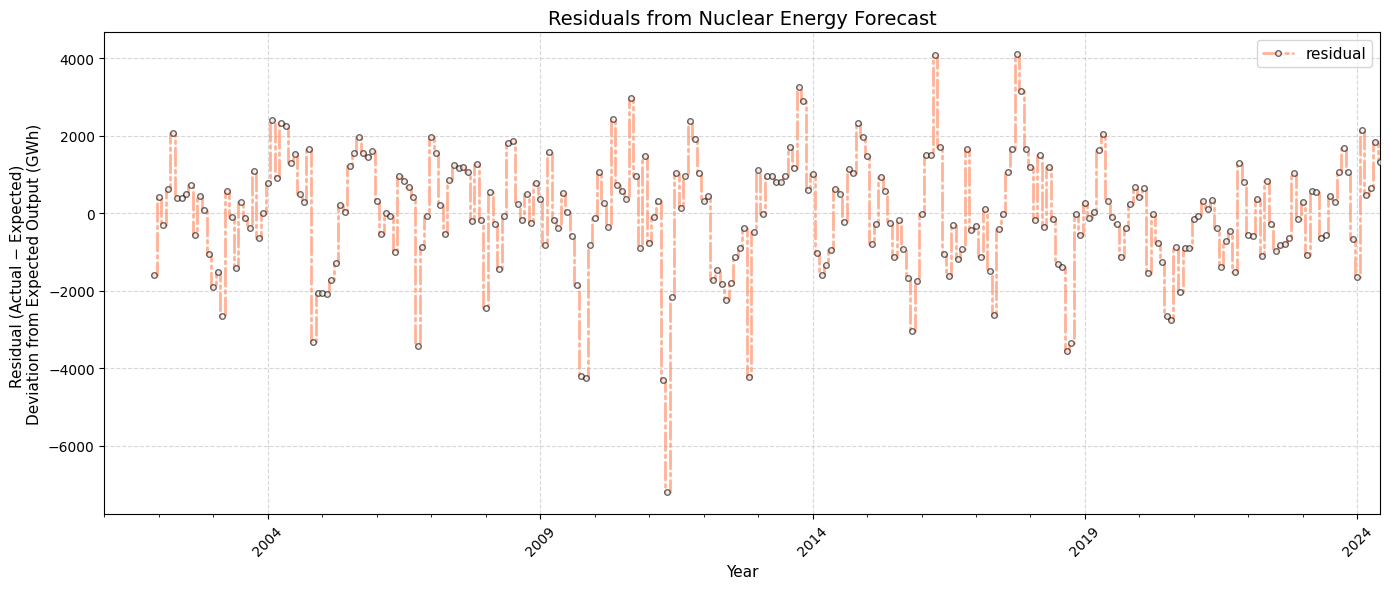

In [49]:
fig, ax = plt.subplots(figsize=(14, 6))

resid.plot(label="residual",
               **trend_options,
               )

style_ax(ax,
         title="Residuals from Nuclear Energy Forecast",
         xlabel="Year",
         ylabel="Residual (Actual − Expected) \nDeviation from Expected Output (GWh)",
         )


plt.tight_layout()
plt.show()

What to Look For in the Residuals:

1. Centered Around Zero:
  * If the residuals fluctuate around 0 consistently, it suggests the model (`expected`) captures the overall trend well.
  * If there's a consistent *positive* or *negative* bias, the model may be under- or over-estimating.

Check - Does the red dashed line at 0 sit in the middle of the cloud of points?


2. Randomness (No Clear Pattern):

  * If the residuals appear *randomly scattered*, the model has likely captured all the predictable structure in the data.
  * If you see *cyclical patterns* or *seasonality* in the residuals, the model (`expected`) may be missing some structure (e.g., a second seasonal component or external factor).

Check - Are there *repeating waves* or *seasonal arcs*? That indicates *underfitting*.


3. Constant Variance (Homoscedasticity):

  * If the spread of residuals stays about the same over time, that's good.
  * If the spread *increases* or *decreases*, it indicates *heteroscedasticity* - our model may not be accounting for changes in variability.

Check - Is the "width" of the residual band changing over time?

4. Outliers:
  * Large spikes (positive or negative) may indicate *anomalies* or *external shocks*
    - (e.g., reactor shutdowns, energy policy changes, natural disasters).

Check - Any large single - point jumps or dips?

In a nutshel:

  If,

  1. Residuals are centered around 0,
  2. No clear patterns,
  3. Spread is stable
  
  Then, the *Model fits well*. Most systematic variation has been captured by the trend/seasonal component.

  If, the Residuals show *structure or cycles* The *Model underfit*.
    - Consider modeling residuals or using a more flexible model.

  If, the Residuals drift above or below 0, then *Bias present*.
    - May need to refine the expected values.

We can think of the residual as the sum of everything in the world that affects energy production, but is not explained by the long-term trend or the seasonal component.
Among other things, that sum includes weather, equipment that's down for maintenance, and changes in demand due to specific events.
Since the residual is the sum of many unpredictable, and sometimes unknowable, factors, we often treat it as a random quantity.


#### 3.5.1.1. Kernel Density Estimate (KDE) plot of the residuals (Residuals are centered around 0?)

Here's what the distribution of the residuals look like.

In [50]:
print('total number of null values \t: ', resid.isnull().sum()) # the first 11 months.
resid = resid.dropna()
print('total number of null values \t: ', resid.isnull().sum())

total number of null values 	:  11
total number of null values 	:  0


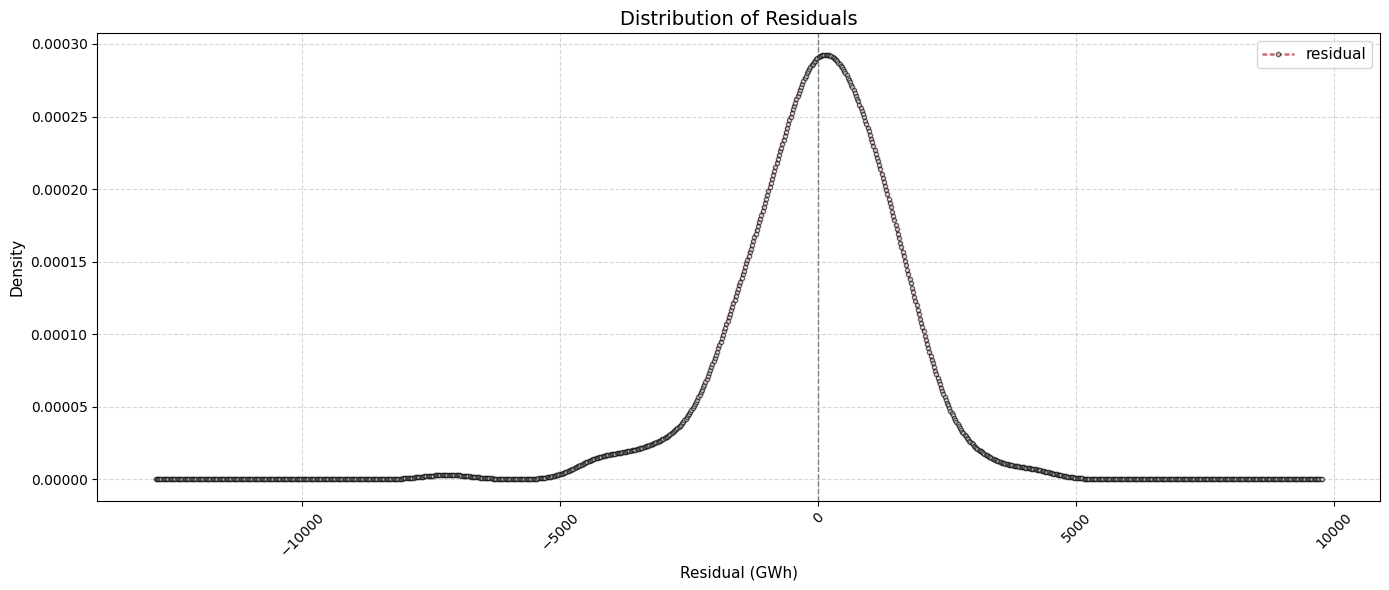

In [51]:
fig, ax = plt.subplots(figsize=(14, 6))

resid.plot(kind = 'kde',
           label="residual",
          **temp_options,
          )

ax.axvline(0,
           color='gray',
           linestyle='--',
           linewidth=1
           )

style_ax(ax,
         title="Distribution of Residuals",
         xlabel="Residual (GWh)",
         ylabel="Density",
         )


plt.tight_layout()
plt.show()

Observations:
  - It resembles the bell curve of the normal distribution
    - which is consistent with the assumption that it is the sum of many random contributions.

It's a *smoothed probability per unit on the X-axis*, such that:

$$
\text{Area under the entire curve} = 1
$$

* X-axis = residuals (in GWh)
* Y-axis = estimated probability density (not % or frequency)
  * *Y-axis = Density* - the height of the probability curve, **not frequency**
  * **Density ≠ Probability** but integrates to 1 over the whole X-axis
    * It’s normal to see small values on the Y-axis when the X-axis range is large


In a *Kernel Density Estimate (KDE)* plot, the Y-axis represents the *estimated probability density* of the residuals.




>  The value `0.0003` in y-axis means: Around that residual value, the probability *density* is \~0.0003.
  - It’s not the probability itself, but the *height* of the density function at that point.

Since, the residuals span a *wide range of values* (from about -10000 to +10000 GWh), the density must be “spread out” to ensure the total area is 1.

The height (Y value) must shrink so that:

$$
\int_{-\infty}^{+\infty} \text{density}(x) \, dx = 1
$$

That’s why the KDE peak is small (e.g., 0.0003), even though visually it looks tall.

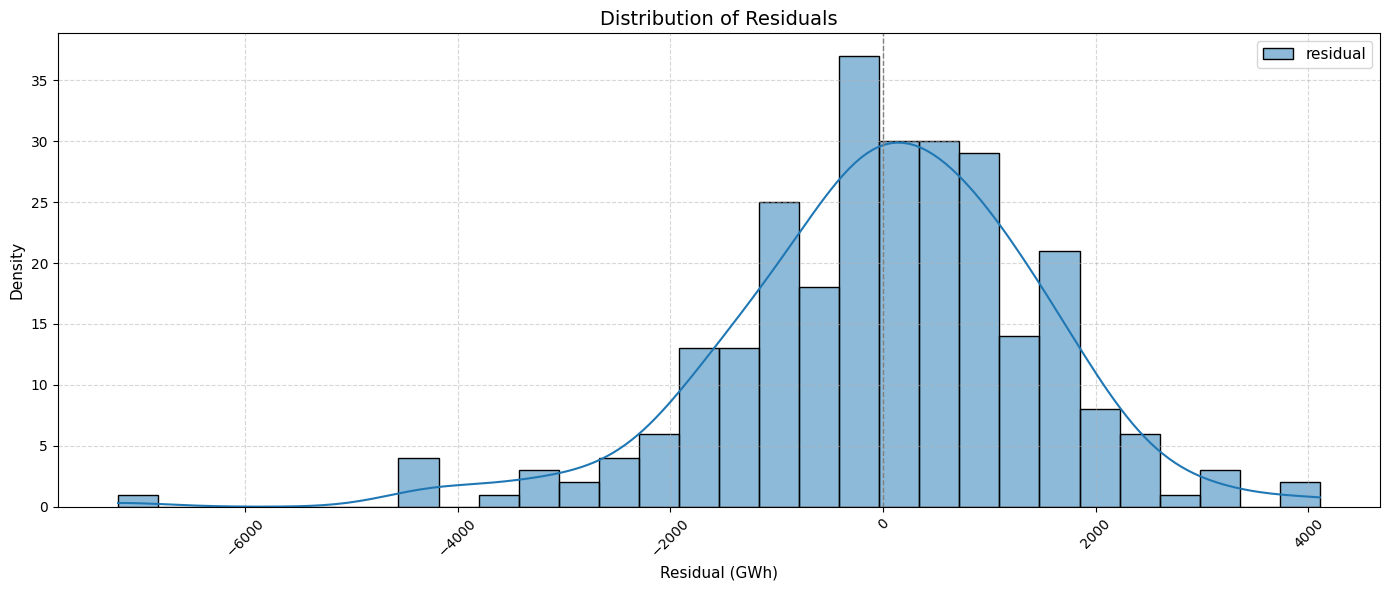

In [52]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.histplot(resid,
             bins=30,
             kde=True,
             label="residual",
             )

ax.axvline(0,
           color='gray',
           linestyle='--',
           linewidth=1
           )

style_ax(ax,
         title="Distribution of Residuals",
         xlabel="Residual (GWh)",
         ylabel="Density",
         )


plt.tight_layout()
plt.show()

Observations:
  - It resembles the bell curve of the normal distribution
    - which is consistent with the assumption that it is the sum of many random contributions.

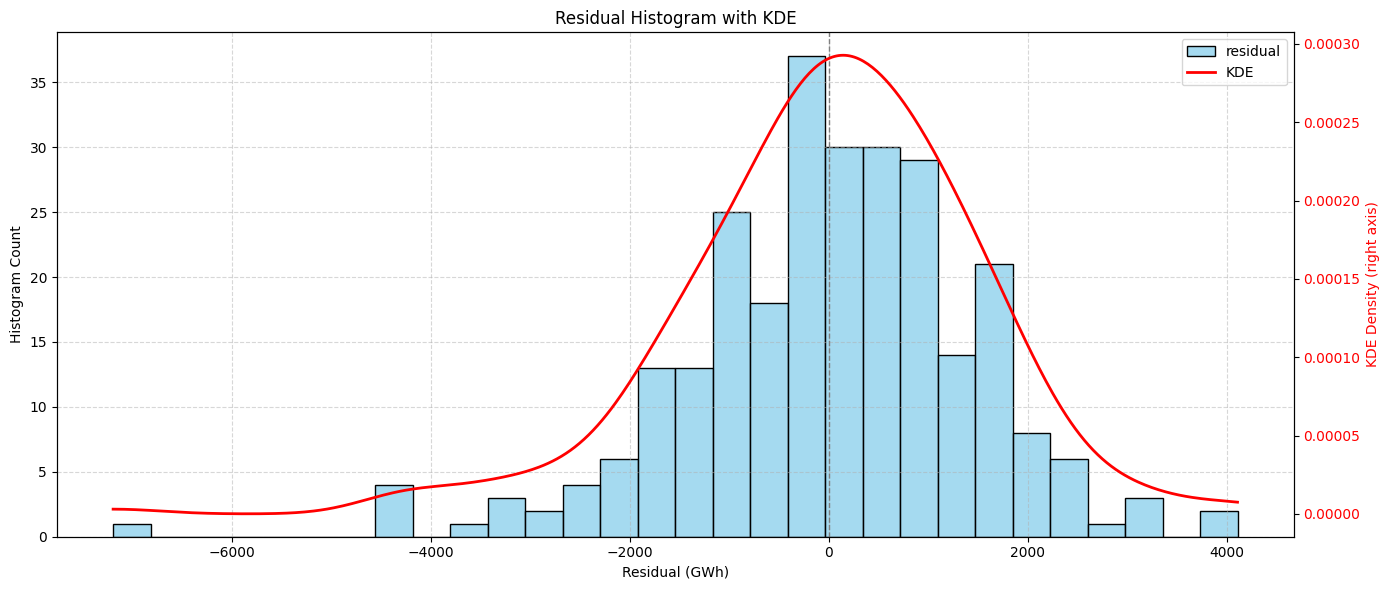

In [53]:
from scipy.stats import gaussian_kde

# Prepare KDE values
x = np.linspace(resid.min(), resid.max(), 500)
kde = gaussian_kde(resid.dropna())
y_kde = kde(x)


fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot histogram on left axis
sns.histplot(resid,
             bins=30,
             kde=False,
             label='residual',
             ax=ax1,
             color='skyblue',
             edgecolor='black'
             )

ax1.set_ylabel("Histogram Count")
ax1.set_xlabel("Residual (GWh)")

# Create secondary axis
ax2 = ax1.twinx()

# Plot KDE on right axis
ax2.plot(x,
         y_kde,
         color='red',
         linewidth=2,
         label="KDE"
         )

ax2.set_ylabel("KDE Density (right axis)",
               color='red'
               )

ax2.tick_params(axis='y',
                labelcolor='red'
                )


ax1.axvline(0, color='gray', linestyle='--', linewidth=1)


ax1.set_title("Residual Histogram with KDE")

# Optional: legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(lines_1 + lines_2,
           labels_1 + labels_2,
           loc='upper right'
           )

grid_style = {'linestyle': '--', 'alpha': 0.5}
ax1.grid(**grid_style)


plt.tight_layout()
plt.show()


Observations:
  - It resembles the bell curve of the normal distribution
    - which is consistent with the assumption that it is the sum of many random contributions.

#### 3.1.6. Variance Explained by the Model (R²)

Now, we have to  quantify **model explanatory power**, which is an essential diagnostic step.

* Computes the *coefficient of determination* (R²)
* Measures how well the *expected values (trend + seasonal)* explain the actual data
* Interprets the *proportion of variance captured by the model*



Because:

* Residuals must be analyzed before choosing a forecasting method
* If R² is **high**, trend + seasonality explain most variation - a naive model may be sufficient
* If R² is **low**, you may need ARIMA or machine learning models to capture what's missing

$$
R^2 = 1 - \frac{\text{Var(Residuals)}}{\text{Var(Observed)}}
$$

This tells us what proportion of the variation in nuclear electricity generation is accounted for by the predictable components of the model.

- An $ R^2 $ close to 1 indicates that the model captures most of the variation in the data.


* `resid = nuclear_data - expected`
* `nuclear_data.var()` is the total variance in the observed data
* `resid.var()` is the variance **unexplained** by the model

In [54]:
rsquared = 1 - resid.var() / nuclear_data.var()
rsquared

0.9054559977513821

Observations:
  - The $R^2$ value is about 0.9, which means that the long-term trend and seasonal component account for 9% of the variability in the series.

## 4. Seasonal Decomposition

The process we've just walked through in section 3 is called *seasonal decomposition*.

StatsModels provides a function that does it, called `seasonal_decompose`.

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(nuclear_data,
                                   model="additive",
                                   period=12
                                   )
decomposition

The `model="additive"` argument indicates the additive model, so the series is decomposed into the sum of a trend, seasonal component, and residual.
We'll see the multiplicative model soon.
The `period=12` argument indicates that the duration of the seasonal component is 12 months.

The result is an object that contains the three components.
The notebook for this chapter provides a function that plots them.

In [56]:
print(decomposition.trend.tail(3))          # Long-term trend
print(decomposition.seasonal.head(3))       # Seasonal component
print(decomposition.resid.head(3))          # Residuals (irregular component)
print(decomposition.observed.head(3))       # Original series (same as nuclear_data)

2024-04-30   NaN
2024-05-31   NaN
2024-06-30   NaN
Freq: ME, Name: trend, dtype: float64
2001-01-31    6340.260170
2001-02-28   -2430.264452
2001-03-31   -1973.599679
Freq: ME, Name: seasonal, dtype: float64
2001-01-31   NaN
2001-02-28   NaN
2001-03-31   NaN
Freq: ME, Name: resid, dtype: float64
2001-01-31    68707.0
2001-02-28    61272.0
2001-03-31    62141.0
Freq: ME, Name: nuclear, dtype: float64


In [57]:
def plot_decomposition(decomposition):
    plt.figure(figsize=(14, 6))

    ax1 = plt.subplot(4, 1, 1)
    plt.plot(decomposition.observed,
             label="Observed",
             color="C9",
             lw=1
             )
    plt.ylabel("Observed")

    plt.subplot(4, 1, 2, sharex=ax1)
    plt.plot(decomposition.trend,
             label="Trend",
             color="C8",
             lw=1
             )
    plt.ylabel("Trend")

    plt.subplot(4, 1, 3, sharex=ax1)
    plt.plot(decomposition.seasonal,
             label="Seasonal",
             color="C7",
             lw=1
             )
    plt.ylabel("Seasonal")

    plt.subplot(4, 1, 4, sharex=ax1)
    plt.plot(decomposition.resid,
             label="Residual",
             color="C6",
             lw=1
             )
    plt.ylabel("Residual")

    plt.tight_layout()

In [58]:
nuclear_data.equals(decomposition.observed)

True

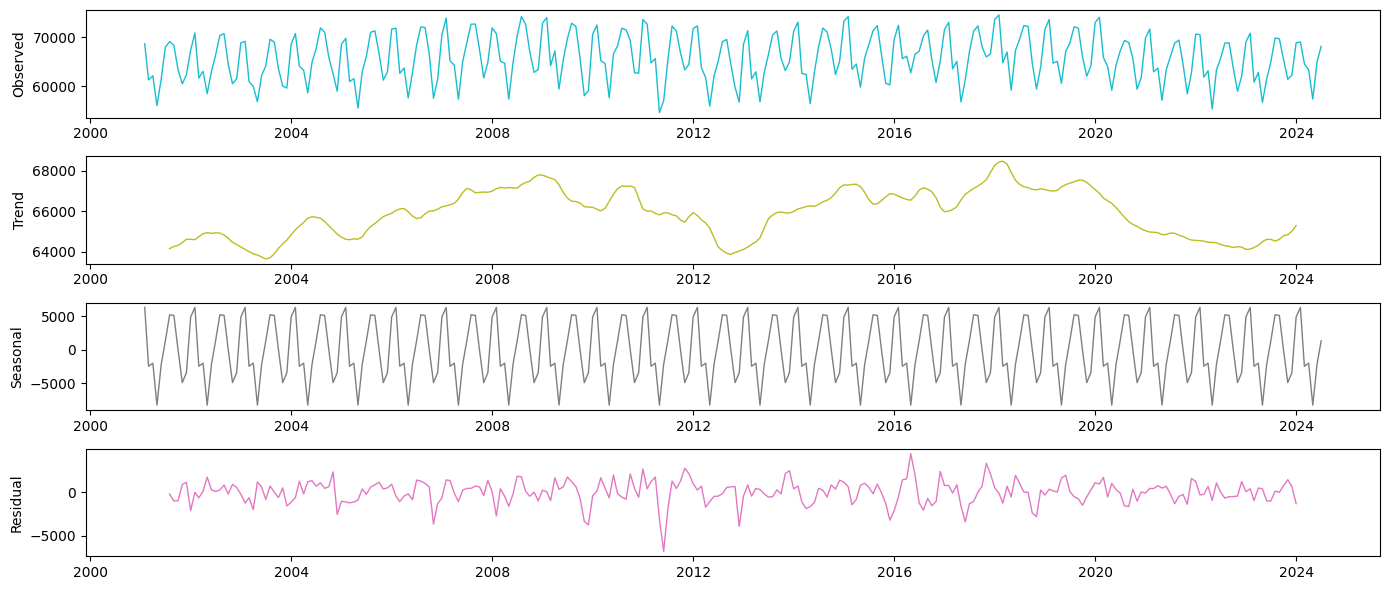

In [59]:
plot_decomposition(decomposition)

Observations:
  - The results are similar to those we computed ourselves, with small differences due to the details of the implementation.

This kind of seasonal decomposition provides insight into the structure of a time series.

As we'll see in the next section, it is also useful for making forecasts.

### 4.1 Residual Diagnostics (ACF and PACF)

 - If there are significant spikes, it means residuals have autocorrelation.
  - Means the model (`trend + seasonality`) did not fully capture the time series structure.

In that case, consider an ARIMA model on the residuals.



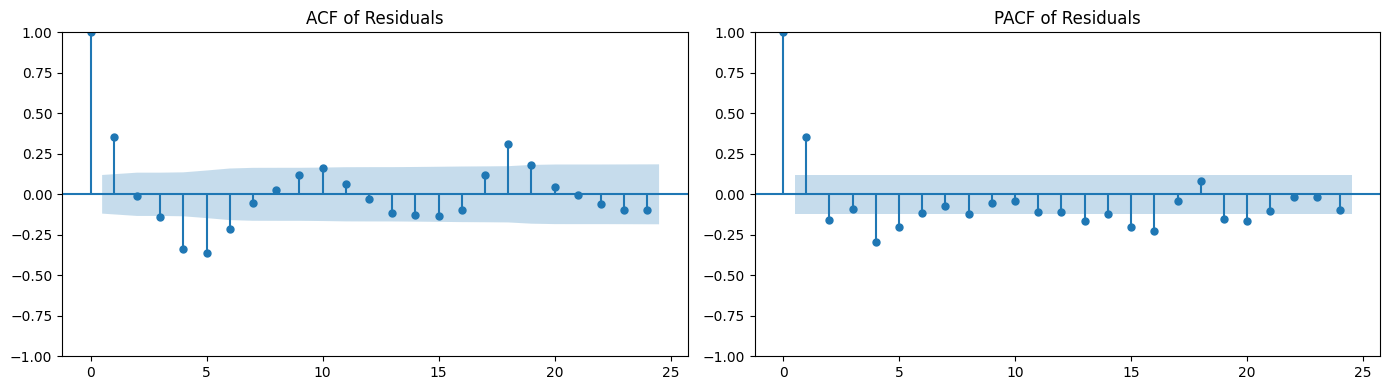

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

resid = decomposition.resid

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(resid.dropna(),
         lags=24, ax=axes[0])
axes[0].set_title("ACF of Residuals")

plot_pacf(resid.dropna(), lags=24, ax=axes[1])
axes[1].set_title("PACF of Residuals")

plt.tight_layout()
plt.show()


Observations from ACF and PACF of Residuals:

- ACF (Left Plot):
  * *Lag 1–3*: Significant positive autocorrelation - spikes well above the confidence band.
  * *Lags 4–12*: Several fall below but remain patterned (some negative dips, small wave).
  * *Lag 18–22*: Slight return of significant spikes.

Interpretation: The residuals *still exhibit autocorrelation*, especially at *short lags*.
  - This suggests that *some short-term structure remains* in the data that was not captured by `trend + seasonal` decomposition.

- PACF (Right Plot):
  * *Lag 1*: Dominant spike - typical of autoregressive structure (AR(1)-like behavior).
  * *Subsequent lags*: Mostly within bounds (though small spikes at 17–20).

Interpretation: Strong partial autocorrelation at lag 1 implies the residuals may follow an *AR(1)* process.

Conclusion:
  * The residuals are *not white noise*.
  * The *trend + seasonal model is insufficient* to explain all structure in the data.
  * There's *significant autocorrelation*, indicating the need for an *additional modeling step*.
  * Fit an *ARIMA or SARIMA model* to the original series or to the residuals
    - especially to capture short-term autocorrelation not explained by trend and seasonality.

## 5. Forecasting with Decomposition

We’ve modeled the known structure. Now, we can use the `trend` + `seasonal model` to forecast future values.

Forecasting methods:
  - Extend the trend (via regression or moving average)
  - Repeat the seasonal pattern
  - Add ARIMA or exponential smoothing to refine




For, we'll use the following function to split the time series into a *training series*, which we'll use to generate predictions, and a *test series*, which we'll use to see whether they are accurate.

In [61]:
df.tail(2)

nuclear  hydroelectric     wind  utility_solar  geothermal  \
2024-05-31  64973.0        21963.0  38936.0        22050.0      1225.0   
2024-06-30  68192.0        21207.0  38330.0        23918.0      1246.0   

            biomass  pumped_storage  small_solar  
2024-05-31   3965.0          -292.0       8592.0  
2024-06-30   3891.0          -586.0       8618.0

In [62]:
def split_series(series, n=60): # 60 months = 5 years in test data
    training = series.iloc[:-n]
    test = series.iloc[-n:]
    return training, test

With `n=60`, the duration of the `test series` is five years, starting in July 2019.

In [63]:
training, test = split_series(nuclear_data)
test.index[0]

Timestamp('2019-07-31 00:00:00')

#### 5.1 Suppose it's June 2019 and you are asked to generate a *five-year forecast* for electricity production from nuclear generators.

To answer this question, we'll use the training data to make a model and then use the model to generate predictions.

#### 5.1.1. We'll start with a seasonal decomposition of the training data.

In [64]:
decomposition = seasonal_decompose(training,
                                   model="additive",
                                   period=12
                                   )
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid
observed = decomposition.observed

By specifying `model='additive'`, you are explicitly telling the procedure that:

$$y_t = Trend_t + Seasonal_t+ Residual_t$$


#### 5.1.2.  Now we'll fit a linear model to the trend.

The explanatory variable, `months`, is the number of months from the beginning of the series.

In [65]:
import statsmodels.formula.api as smf #stats models formula.

months = np.arange(len(trend))

data = pd.DataFrame({"trend": trend,
                     "months": months
                     }).dropna()

data.head(2)

trend  months
2001-07-31  64161.208333       6
2001-08-31  64269.750000       7

In [66]:
model = smf.ols("trend ~ months",  #Ordinary Least Squares regression
                  data=data
                  ).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  trend   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     110.9
Date:                Fri, 06 Jun 2025   Prob (F-statistic):           4.66e-21
Time:                        03:03:58   Log-Likelihood:                -1729.3
No. Observations:                 210   AIC:                             3463.
Df Residuals:                     208   BIC:                             3469.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.482e+04    131.524    492.869      0.0

In [67]:
print(model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.482e+04    131.524    492.869      0.000    6.46e+04    6.51e+04
months        10.9886      1.044     10.530      0.000       8.931      13.046


Observations

1. Estimated Coefficients

   * *months* - Each additional month is associated with an average increase of about 10.99 units in the response variable.

2. Standard Errors and Precision

   * The standard error for the `intercept` is 131.524, which is very small relative to the coefficient (≈ 64,820), indicating a highly precise estimate.
   * The standard error for the `months` is 1.044, also small compared to 10.9886, suggesting that the estimate of the monthly effect is reliable.

3. t-Values and Significance

   * Intercept: $t = 492.869$, $p < 0.05$.
   * Months: $t = 10.530$, $p < 0.05$.
      - In both cases, the $p$-values are effectively zero, meaning we strongly reject the null hypothesis that each coefficient equals zero.
      - Both coefficients are highly statistically significant.

4. 95% Confidence Intervals

   * Intercept: \[64,600; 65,100] (approximately).
      - We can be 95% confident that the true intercept lies between 64,600 and 65,100.
   * impact (months): \[8.931; 13.046].
      - With 95% confidence, each additional month contributes between approximately 8.93 and 13.05 units to the response.

Conclusions

1. There is a clear, positive, and statistically significant linear relationship between `months` and the dependent variable.
  - each extra month adds about 10.99 units on average.
2. Both the intercept and the slope are estimated with high precision (low standard errors) and have $p$-values far below 0.05.
  - the model captures the central trend in the data well.


Recommendations

1. Verify Model Assumptions
2. Using the Model for Prediction
  $$\hat{y} = 64{,}820 + 10.9886 \times (\text{months})$$
   * Always provide prediction intervals (not just confidence intervals) to convey the uncertainty around individual forecasts.

3. Consider Model Extensions

   * If the relationship appears nonlinear over a broader range, consider adding a quadratic term (e.g., $\text{months}^2$) or applying a transformation (e.g., log or square root).
   * If there are other relevant factors (seasonality, economic indicators, etc.), include them as additional predictors to improve model fit.

4. Evaluate prediction accuracy with metrics like RMSE or MAE.

In [68]:
print(model.rsquared)

0.3477264297898065


Observations:

- The $R^2$ value is about 0.35, which suggests that the model does not fit the data particularly well.



In [69]:
print("R-squared \t :", model.rsquared)
print("Adjusted R-squared \t :", model.rsquared_adj)
print("F-statistic \t :", model.fvalue)
print("Prob (F-statistic) \t :", model.f_pvalue)
print("AIC \t :", model.aic)
print("BIC \t :", model.bic)

# Print residual diagnostics
print("Mean of residuals \t :", model.resid.mean())
print("Standard error of regression \t :", model.mse_resid ** 0.5)

# Optional: get coefficients
print("\nCoefficients \t :")
print(model.params)
print(model.params.Intercept)
print(model.params.months)

# Optional: p-values
print("\nP-values \t :")
print(model.pvalues)
print(model.pvalues.Intercept)
print(model.pvalues.months)


R-squared 	 : 0.3477264297898065
Adjusted R-squared 	 : 0.3445904991637959
F-statistic 	 : 110.88460532437722
Prob (F-statistic) 	 : 4.663024143373341e-21
AIC 	 : 3462.6858351855544
BIC 	 : 3469.3800502469894
Mean of residuals 	 : -1.3789672049738111e-11
Standard error of regression 	 : 916.7295196700834

Coefficients 	 :
Intercept    64823.886034
months          10.988627
dtype: float64
64823.886034272844
10.98862742811341

P-values 	 :
Intercept    4.940656e-321
months        4.663024e-21
dtype: float64
4.94e-321
4.663024143379006e-21


#### 5.1.3.  We can get a better sense of that by plotting the fitted line.

We'll use the `predict` method to compute expected values for the training and test data.

In [70]:
print('training lengith is \t:', len(training))
print('test lengith is \t:', len(test))

months = np.arange(len(training) + len(test))
months

training lengith is 	: 222
test lengith is 	: 60


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [71]:
ndf = pd.DataFrame({"months": months})
ndf.tail()

months
277     277
278     278
279     279
280     280
281     281

In [72]:
pred_trend = model.predict(ndf)
pred_trend.tail()

277    67867.735832
278    67878.724459
279    67889.713087
280    67900.701714
281    67911.690342
dtype: float64

In [73]:
pred_trend.index = nuclear_data.index
pred_trend.tail()

2024-02-29    67867.735832
2024-03-31    67878.724459
2024-04-30    67889.713087
2024-05-31    67900.701714
2024-06-30    67911.690342
Freq: ME, dtype: float64

Here's the trend component and the linear model.

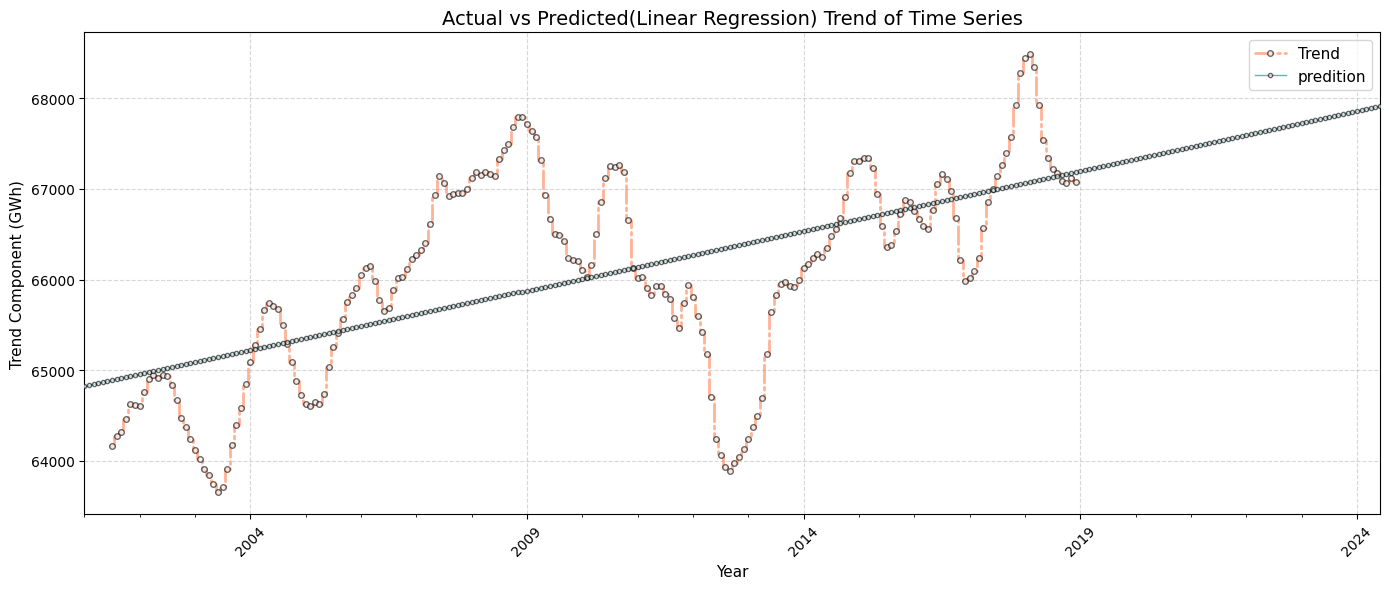

In [74]:
fig, ax = plt.subplots(figsize=(14, 6))

trend.plot(label="Trend",
               **trend_options,
               )

pred_trend.plot(label="predition",
               **line_options,
               )

style_ax(ax,
         title="Actual vs Predicted(Linear Regression) Trend of Time Series",
         xlabel="Year",
         ylabel="Trend Component (GWh)",
         )


plt.tight_layout()
plt.show()

Observations:
  - There's a lot going on that's not captured by the linear model
  - But it looks like there is a generally increasing trend.

#### 5.1.4.   Now we'll use the seasonal component from the decomposition to compute a `Series` of monthly averages.

In [75]:
print(seasonal.tail(2))
print('\nshape\t:',seasonal.shape)

2019-05-31   -2290.482321
2019-06-30    1444.738267
Freq: ME, Name: seasonal, dtype: float64

shape	: (222,)


In [76]:
seas_months = seasonal.index.month
seas_months

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6],
      dtype='int32', length=222)

In [77]:
monthly_averages = seasonal.groupby(seas_months).mean().round(2)
monthly_averages.tail(2)

11   -3591.22
12    4881.31
Name: seasonal, dtype: float64

We can predict the seasonal component by looking up the dates from the fitted line in `monthly_averages`.

In [78]:
pred_months = pred_trend.index.month
pred_months

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6],
      dtype='int32', length=282)

In [79]:
pred_seasonal = monthly_averages[pred_months]
pred_seasonal.tail()

2   -2477.19
3   -2038.62
4   -8361.32
5   -2290.48
6    1444.74
Name: seasonal, dtype: float64

In [80]:
pred_seasonal.index = pred_trend.index
pred_seasonal.tail()

2024-02-29   -2477.19
2024-03-31   -2038.62
2024-04-30   -8361.32
2024-05-31   -2290.48
2024-06-30    1444.74
Freq: ME, Name: seasonal, dtype: float64

Finally, to generate predictions, we'll add the seasonal component to the trend.

In [81]:
pred = pred_trend + pred_seasonal
pred.tail()

2024-02-29    65390.545832
2024-03-31    65840.104459
2024-04-30    59528.393087
2024-05-31    65610.221714
2024-06-30    69356.430342
Freq: ME, dtype: float64

Here's the training data and the predictions.

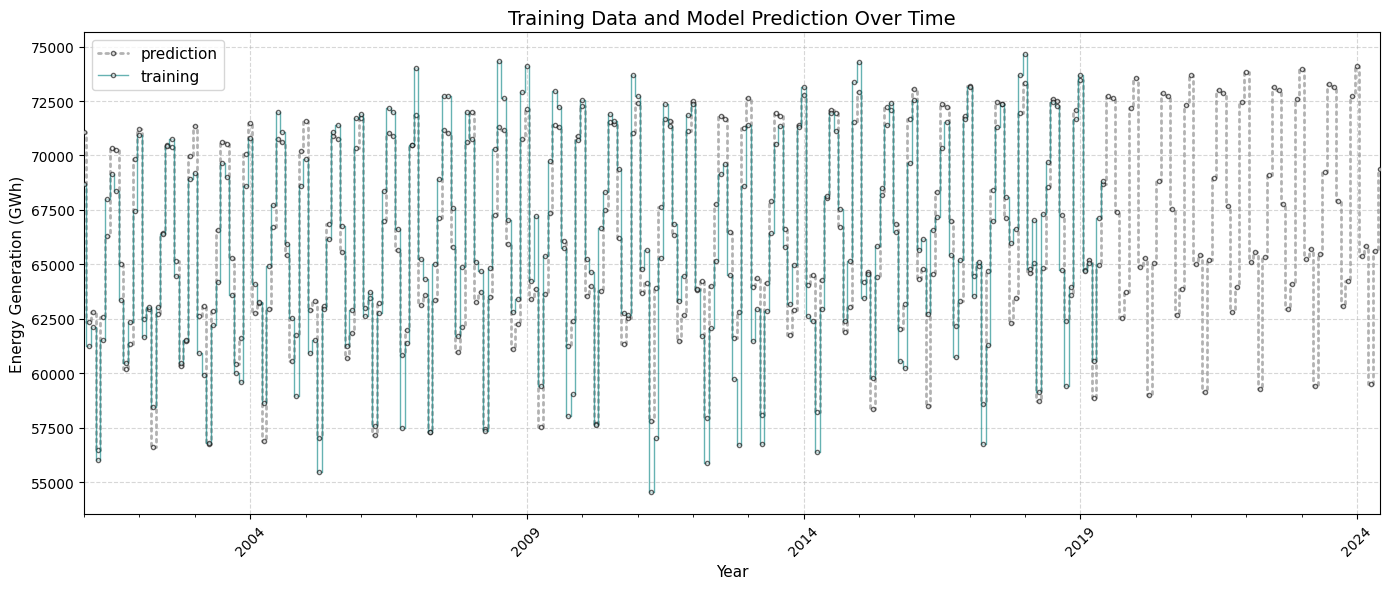

In [82]:
fig, ax = plt.subplots(figsize=(14, 6))

pred.plot(label="prediction",
          **pred_options
          )

training.plot(label="training",
              **line_options
              )

style_ax(ax,
         title="Training Data and Model Prediction Over Time",
         xlabel="Year",
         ylabel="Energy Generation (GWh)",
         )


plt.tight_layout()
plt.show()

Observations:
  - The predictions fit the training data reasonably well
  - The forecast looks like a reasonable projection, based on the assumption that the long-term trend will continue.

#### 5.1.5.   Now, from the vantage point of the future, let's see how accurate this forecast turned out to be.

Here are the predicted and actual values for the five-year interval from July 2019.

``` pred = pred_trend + pred_seasonal ```

In [83]:
pred.tail(2)

2024-05-31    65610.221714
2024-06-30    69356.430342
Freq: ME, dtype: float64

In [84]:
forecast = pred[test.index]
forecast.tail(2)

2024-05-31    65610.221714
2024-06-30    69356.430342
Freq: ME, dtype: float64

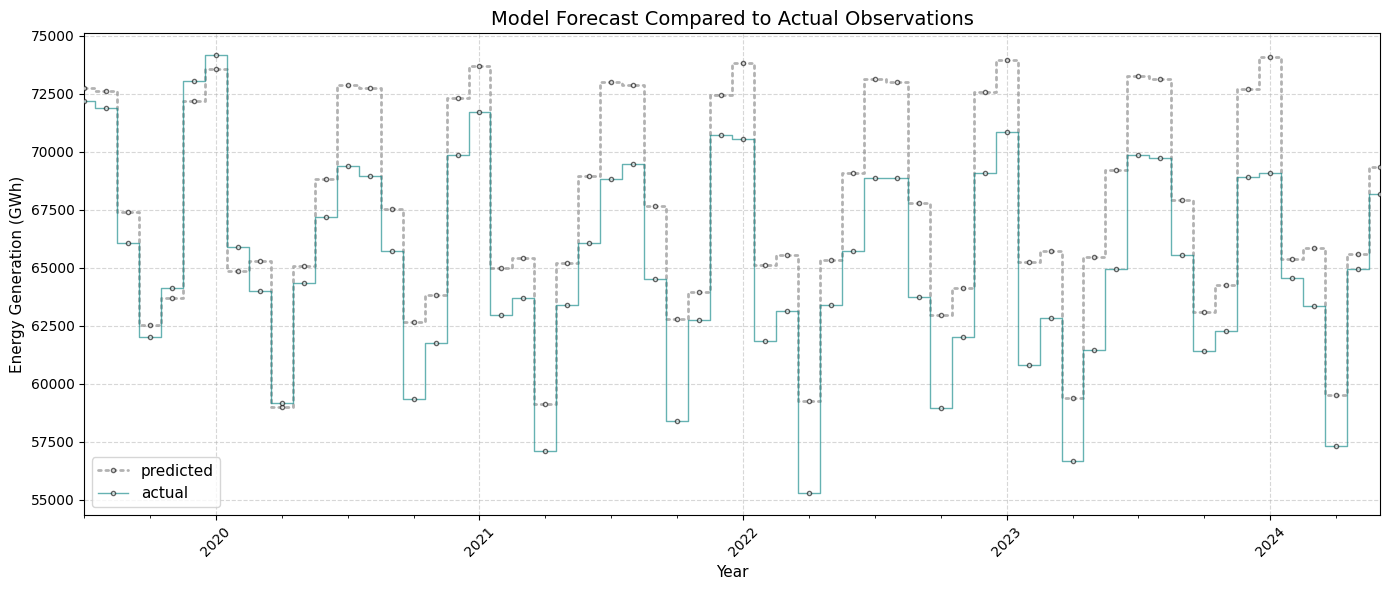

In [85]:
fig, ax = plt.subplots(figsize=(14, 6))

forecast.plot(label="predicted",
          **pred_options
          )

test.plot(label="actual",
              **line_options
              )

style_ax(ax,
         title="Model Forecast Compared to Actual Observations",
         xlabel="Year",
         ylabel="Energy Generation (GWh)",
         )


plt.tight_layout()
plt.show()

Observations:
  - The first year of the forecast was pretty good
  - But production from nuclear reactors in 2020 was lower than expected
    - possibly due to the COVID-19 pandemic
    - and it never returned to the long-term trend.

#### 5.1.6.   To quantify the accuracy of the predictions, we'll use the Mean Absolute Percentage Error (MAPE).

MAPE - *Mean Absolute Percentage Error* - answers:

> "On average, by what *percentage* was my forecast off from the actual value?"

Unlike RMSE or MAE which are in raw units, *MAPE is unitless* and expressed as a percentage - making it easily interpretable.


APE - Absolute Percentage Error : for a single time point $t$:

   $$
   \text{APE}_t \;=\; \left|\frac{A_t - F_t}{A_t}\right|\times 100
   $$

This tells you the percentage error at time $t$.

MAPE over $n$ points:

   $$
   \text{MAPE} \;=\; \frac{1}{n} \sum_{t=1}^n \text{APE}_t \;=\; \frac{1}{n}\sum_{t=1}^n \left|\frac{A_t - F_t}{A_t}\right|\times 100.
   $$



Where:

* $A_t$: actual value at time $t$
* $F_t$: forecasted value
* $n$: number of forecast points




APE tells us:

> “By what percentage was I off at time $t$?”

MAPE tells us:

> “On average, how far off was my model, as a percentage of actual values?”



Example:

Let’s say:

* Predicted value is 105 GWh
* Actual value is 100 GWh

Then:

$$
\text{MAPE} = \left| \frac{100 - 105}{100} \right| \times 100 = 5\%
$$

> So the forecast is 5% off from the truth.

MAPE *averages* that error over all points.

When MAPE fails (and can lie):

1.  Division by Zero.

  If *any actual value is 0*, then:

  $$ \frac{F_t - A_t}{A_t} $$

  is *undefined* ->  division by zero.

  *Workaround:*
    -  Filter out zeros or use a modified metric.



2. Explodes for small actuals.

  If Actual = 0.1 and Forecast = 2.0. Then  MAPE = 1900%

  That one value dominates the average.

3. Biased toward under-forecasting:

    *MAPE punishes over-prediction more*.
  - actual 50, predition is 100. MAPE = 100%
  - actual 150, predition is 100. MAPE = 150%

  MAPE punishes over-prediction more when forecast values are large and actual is small

4. MAPE appropriate When:

  * Actual values are *never 0* and *not very small*
  * You want *relative error* instead of absolute error
  * You're comparing *multiple models across different scales*

5. Alternatives to MAPE.

  5.1. MAE : Mean Absolute Error
  
  5.2. RMSE : Root Mean Squared Error

  5.3. SMAPE : Symmetric Mean Absolute Percentage Error

  5.4. MASE : Mean Absolute Scaled Error

  5.5. MAPE with ε : Mean Absolute Percentage Error (with ε-adjustment to avoid division by zero)



In [86]:
def MAPE(predicted, actual):
    ape = np.abs(predicted - actual) / actual
    return np.mean(ape) * 100

In [87]:
MAPE(forecast, test)

np.float64(3.8119399413744084)

In this example, the predictions are off by 3.81% on average.

Can we do better with a different model?

  - we will answer later.

## 6. Multiplicative Model

The additive model we used in the previous section:

`model='additive'`:

$$y_t = Trend_t + Seasonal_t+ Residual_t$$

 assumes that the `time series` is the *sum* of a long-term `trend`, a `seasonal component`, and a `residual` - which implies that the magnitude of the seasonal component and the residuals does not vary over time.

As an example that violates this assumption, let's look at small-scale solar electricity production since 2014.

In [88]:
df.tail(2)

nuclear  hydroelectric     wind  utility_solar  geothermal  \
2024-05-31  64973.0        21963.0  38936.0        22050.0      1225.0   
2024-06-30  68192.0        21207.0  38330.0        23918.0      1246.0   

            biomass  pumped_storage  small_solar  
2024-05-31   3965.0          -292.0       8592.0  
2024-06-30   3891.0          -586.0       8618.0

In [89]:
solar_data = df["small_solar"]

missing_count = solar_data.isna().sum()
print(f"The missing values in the solar data \t :{missing_count} ")

solar_data = solar_data.dropna()
print(f"The cleaned solar_data observations \t :{len(solar_data)}")

solar_data.tail(2)


The missing values in the solar data 	 :156 
The cleaned solar_data observations 	 :126


2024-05-31    8592.0
2024-06-30    8618.0
Freq: ME, Name: small_solar, dtype: float64

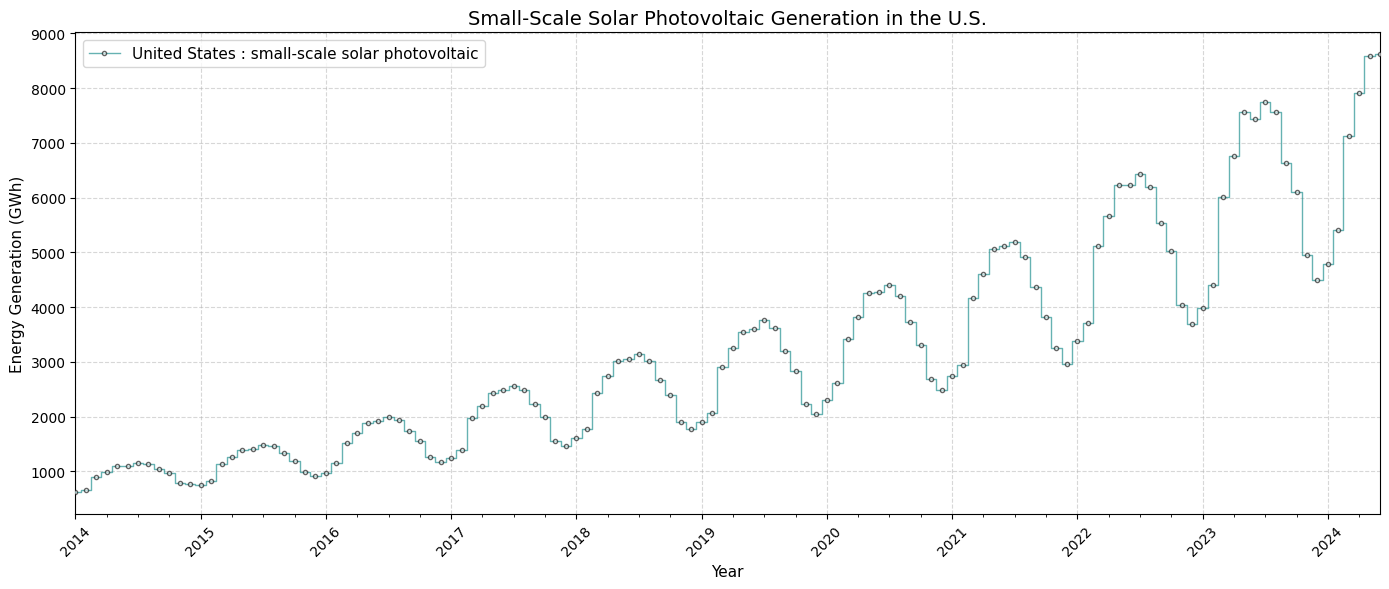

In [90]:
fig, ax = plt.subplots(figsize=(14, 6))

solar_data.plot(label="United States : small-scale solar photovoltaic",
          **line_options
          )

style_ax(ax,
         title="Small-Scale Solar Photovoltaic Generation in the U.S.",
         xlabel="Year",
         ylabel="Energy Generation (GWh)",
         )


plt.tight_layout()
plt.show()

Observation:

  - Over this interval, total production has increased several times over.
  - And it's clear that the magnitude of seasonal variation has increased as well.

If we suppose that the magnitudes of seasonal and random variation are proportional to the magnitude of the trend, that suggests an alternative to the additive model in which the time series is the *product* of the three components.

To try out this multiplicative model, we'll split this series into training and test sets.

In [91]:
training, test = split_series(solar_data)
print("solar data length is \t:", len(solar_data))
print("training length is \t:", len(training))
print("test data length is \t:", len(test))

solar data length is 	: 126
training length is 	: 66
test data length is 	: 60


### 6.1. Seasonal Decompose

And call `seasonal_decompose` with the `model="multiplicative"` argument.

In [92]:
decomposition = seasonal_decompose(training,
                                   model="multiplicative",
                                   period=12
                                   )
decomposition



```
seasonal_decompose(training, model="multiplicative", period=12)
```
Breaks our training data into *trend × seasonality × noise*, assuming *seasonality scales with the trend*, and repeats *every 12 periods*.


This `seasonal_decompose` function *separates time series* into three components:

1. *Trend* : long-term movement
2. *Seasonal* : repeating patterns (e.g. monthly, yearly)
3. *Residual* : what's left (noise, irregularity)


`model="multiplicative` specifies *how the three components combine* to form your original time series.

Two options:

1. *Additive model*

  Assumes $ Y_t = T_t + S_t + R_t $

  Where:

    * $Y_t$: observed value at time $t$
    * $T_t$: trend
    * $S_t$: seasonal
    * $R_t$: residual

  Use this when:

    * Seasonal variations are **constant in size** over time
    * Example: each December adds \~10 GWh to baseline

2. *Multiplicative model*

  Assumes $Y_t = T_t \times S_t \times R_t$

  Use this when:

    * Seasonal variation *scales with the trend*

Example: as solar power grows, seasonal highs/lows become *more exaggerated*



| Month | Additive (flat variation) | Multiplicative (growing variation) |
| ----- | ------------------------- | ---------------------------------- |
| Jan   | 100 + 10 = 110            | 100 × 1.10 = 110                   |
| Jun   | 200 + 10 = 210            | 200 × 1.10 = 220                   |



 `period=12` tells the function that *our seasonal cycle repeats every 12 time units*.





Here's what the results look like.

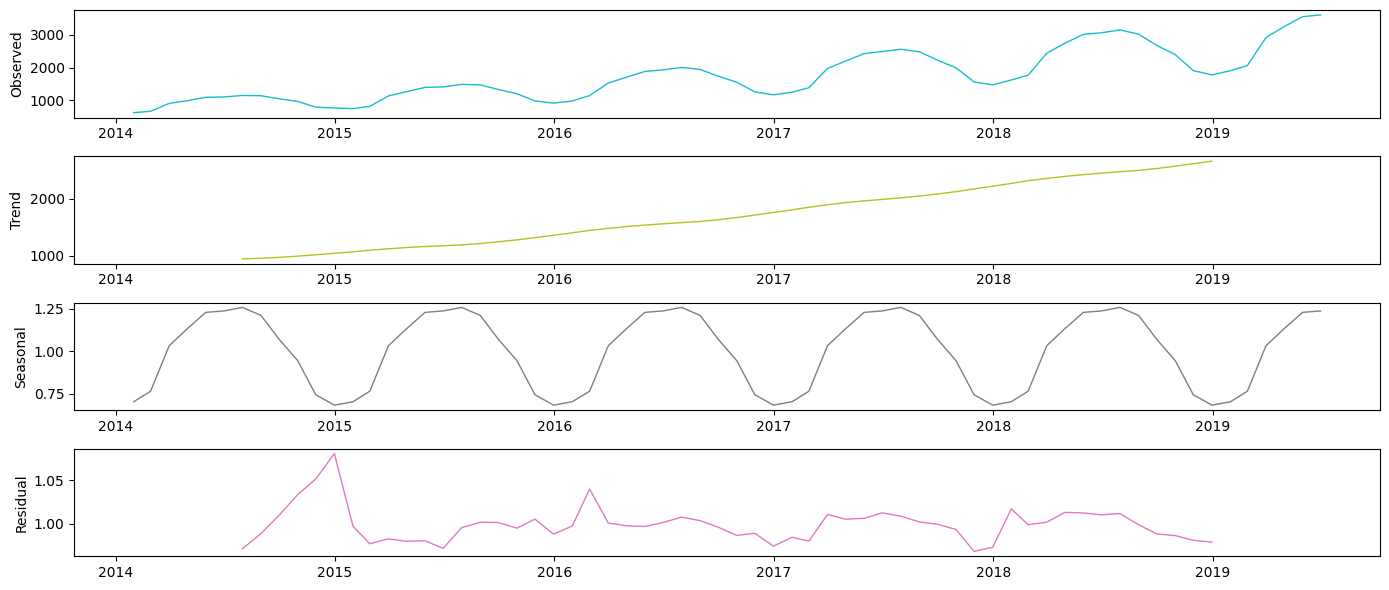

In [93]:
plot_decomposition(decomposition)

In [94]:
training.equals(decomposition.observed)# just to confirm

True

Observations:

  - Now the seasonal and residual components are multiplicative factors.
  - It looks like the seasonal component varies from about 25% below the trend to 25% above.
  - The residual component is usually less than 5% either way, with the exception of some larger factors in the first period.

We can extract the components of the model like this.

In [95]:
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid
observed = decomposition.observed

print(f"trend length :\t\t {len(trend)}")
print(f"seasonal length  :\t {len(seasonal)}")
print(f"resid length  :\t\t {len(resid)}")
print(f"observed length :\t {len(observed)}")

print(f"\ntrend missing values :\t {trend.isna().sum()}")
print(f"seasnl missing values :\t {seasonal.isna().sum()}")
print(f"resid missing values :\t {resid.isna().sum()}")
print(f"obsrvd missing values :\t {observed.isna().sum()}")

trend length :		 66
seasonal length  :	 66
resid length  :		 66
observed length :	 66

trend missing values :	 12
seasnl missing values :	 0
resid missing values :	 12
obsrvd missing values :	 0


When we run an `additive decomposition` with a specified seasonal period (for example, 12 months), Statsmodels uses a centered moving‐average filter to estimate the trend.

- A centered moving average of length 12 cannot be computed for the first 6 and last 6 observations
  - This leads to 6 + 6 = 12 missing values.

#### 6.1.1. Variance Explained by Decomposition ($R^2$ Equivalent)


$$
R^2 = 1 - \frac{\text{Var}(\text{residual})}{\text{Var}(\text{observed})}
$$

```
rsquared = 1 - resid.var() / training.var()
```

is computing a version of the *coefficient of determination* $R^2$ - tells how well a model explains the variation in a dataset.


* `resid.var()` - the variance of the `residuals` (what’s not explained by your model)
* `training.var()` - the variance of the `original (observed) series`



In context of decomposition:

$R^2$ tells - *goodness of fit* of our seasonal decomposition.
  -  *how much of the variation in the original series is explained* by the *trend + seasonal* components
    -  resid = original − expected
  - $R^2$ ≈ 1.0 : Decomposition explains most variation
  - $R^2$ ≈ 0.0 : Model explains little variation

In [96]:
rsquared = 1 - resid.var() / training.var()
rsquared

0.9999999992978134

The $R^2$ value of this model is very high.

Observation:

  The production of a solar panel is largely a function of the sunlight it's exposed to, so it makes sense that production follows an annual cycle so closely.


### 6.2. Prediction long term trend

To predict the long term trend, we'll use a quadratic model.

In [97]:
train_months = range(len(training))
train_months

range(0, 66)

In [98]:
data = pd.DataFrame({"trend": trend,
                     "months": train_months}
                    ).dropna()
data.tail() # 6 + 6 = 12 missing values

trend  months
2018-08-31  2497.375000      55
2018-09-30  2529.583333      56
2018-10-31  2570.625000      57
2018-11-30  2614.083333      58
2018-12-31  2659.208333      59



```python
model = smf.ols("trend ~ months + I(months**2)", data=data).fit()
```

The `I(...)` is short for *Identity* in the formula language (from `patsy`, which `statsmodels` uses).

  - Without `I(...)`, `months**2` would be parsed incorrectly or even throw an error because the formula parser expects variable names and operators, not raw Python expressions.



It fits a **quadratic regression**:

$$
\text{trend} = \beta_0 + \beta_1 \cdot \text{months} + \beta_2 \cdot \text{months}^2 + \varepsilon
$$

This is useful when you suspect a *non-linear trend* over time
  -  Eg: if the rate of change in `trend` is accelerating or decelerating.



In [99]:
model = smf.ols("trend ~ months + I(months**2)",
                data=data
                ).fit()

In the Patsy formula, the substring `I(months**2)` adds a quadratic term to the model, so we don't have to compute it explicitly.
Here are the results.

Physical/Visual Meaning of $months^2$:

1. Captures Acceleration or Deceleration in Trend:

   * A linear model (`trend ~ months`) assumes a constant rate of change.
   * Adding $months^2$ allows the model to account for *changing rates*
    - the trend could *speed up* or *slow down* over time.

2. Concave or Convex Shape:

   * If the coefficient of $months^2$ is *positive*, the curve is *convex* ($\cup$ shaped)
    - trend starts slow, increases faster over time.
   * If the coefficient is *negative*, the curve is *concave* ($\cap$ shaped)
    -  trend increases but the rate of increase slows down, or even reverses.

3. Inflection Point Possibility:

   * The quadratic form allows the model to *peak* or *dip* at a certain month, indicating a possible turning point in the trend.


Eg: Suppose `trend` is average housing prices over time:

* A linear model might say: *“Housing prices go up by \$100 every month.”*
* A quadratic model might say: *“Housing prices go up faster each month*  by:
  - $\$\ 80$ in month 1,
  - $\$\ 100$ in month 2,
  - $\$\ 130$ in month 3, etc.
  -  that’s *acceleration*.

In [100]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  trend   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.473e+04
Date:                Fri, 06 Jun 2025   Prob (F-statistic):           3.64e-71
Time:                        03:04:04   Log-Likelihood:                -243.27
No. Observations:                  54   AIC:                             492.5
Df Residuals:                      51   BIC:                             498.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        766.1962     13.494     56.

Observation:


  - The p-values of the linear and quadratic terms are very small
    - which suggests that the quadratic model captures more information about the trend than a linear model would
  - The $R^2$ value is very high.

### 6.3.  Now we can use the model to compute the expected value of the trend for the past and future.

In [101]:
months_original = range(len(solar_data))
months_original

range(0, 126)

In [102]:
ndf = pd.DataFrame({"months": months_original})
ndf.tail()

months
121     121
122     122
123     123
124     124
125     125

In [103]:
pred_trend = model.predict(ndf) # we have the full prediction values. We gave month id to predict.
pred_trend.tail()

121    6033.556480
122    6098.581162
123    6163.958184
124    6229.687548
125    6295.769251
dtype: float64

In [104]:
pred_trend.index = solar_data.index
pred_trend.tail()

2024-02-29    6033.556480
2024-03-31    6098.581162
2024-04-30    6163.958184
2024-05-31    6229.687548
2024-06-30    6295.769251
Freq: ME, dtype: float64

Here's what it looks like.

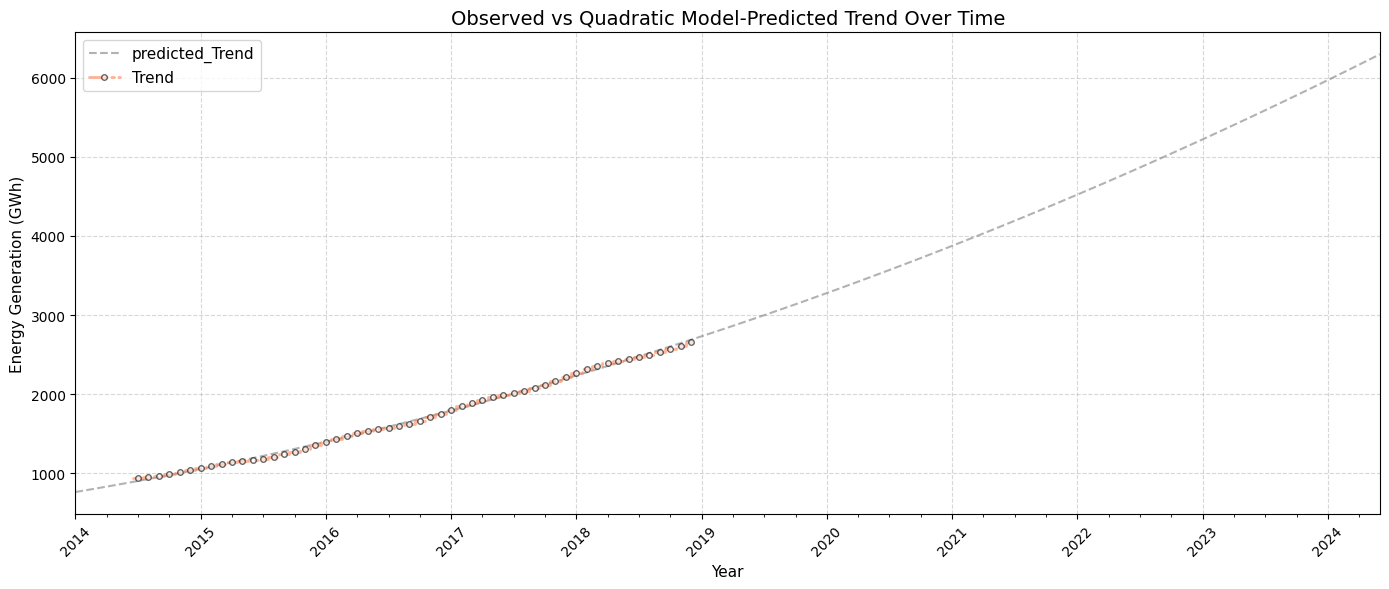

In [105]:
fig, ax = plt.subplots(figsize=(14, 6))

pred_trend.plot(label="predicted_Trend",
          **model_options
          )

trend.plot(label="Trend",
              **trend_options
              )

style_ax(ax,
         title="Observed vs Quadratic Model-Predicted Trend Over Time",
         xlabel="Year",
         ylabel="Energy Generation (GWh)",
         )


plt.tight_layout()
plt.show()

Observations:

* The quadratic curve closely follows the historical trend, capturing accelerating growth in energy generation.
* Trend steepens after 2016, indicating faster increases over time.

Conclusions

* A quadratic fit is appropriate for short‐term forecasting (2019–2020) since residuals appear minimal.
* Long‐term extrapolation (to 2024) may overstate growth if acceleration slows or capacity limits emerge.

Recommendations

* Validate the quadratic forecast against any available 2019–2020 data.
* Combine this trend with the seasonal component and check residuals for remaining patterns.
* Reassess the trend form (piecewise or logistic) if future data deviate significantly from the quadratic path.




### 6.4. Now we can use the `seasonal` component to predict future seasonal variation.

In [106]:
monthly_averages = seasonal.groupby(seasonal.index.month).mean()
monthly_averages

1     0.702190
2     0.764117
3     1.031662
4     1.131404
5     1.228092
6     1.236604
7     1.257391
8     1.209731
9     1.069890
10    0.943668
11    0.743142
12    0.682110
Name: seasonal, dtype: float64

In [107]:
pred_seasonal = monthly_averages[pred_trend.index.month] #assumes a multiplicative seasonal model; seasonality is yearly, and each month has a consistent seasonal factor.
pred_seasonal.tail()

2    0.764117
3    1.031662
4    1.131404
5    1.228092
6    1.236604
Name: seasonal, dtype: float64

In [108]:
pred_seasonal.index = pred_trend.index
pred_seasonal.tail()

2024-02-29    0.764117
2024-03-31    1.031662
2024-04-30    1.131404
2024-05-31    1.228092
2024-06-30    1.236604
Freq: ME, Name: seasonal, dtype: float64

Finally, to compute *retrodictions* for past values and predictions for the future, we multiply the trend and the seasonal component.



This is the *final forecast or retrodiction*, using a *multiplicative decomposition model*:

$$
\text{Prediction}_t = \text{Trend}_t \times \text{Seasonality}_t
$$




In [109]:
pred = pred_trend * pred_seasonal
pred.tail()

2024-02-29    4610.340635
2024-03-31    6291.674766
2024-04-30    6973.926758
2024-05-31    7650.630068
2024-06-30    7785.376378
Freq: ME, dtype: float64

Here is the result along with the training data.

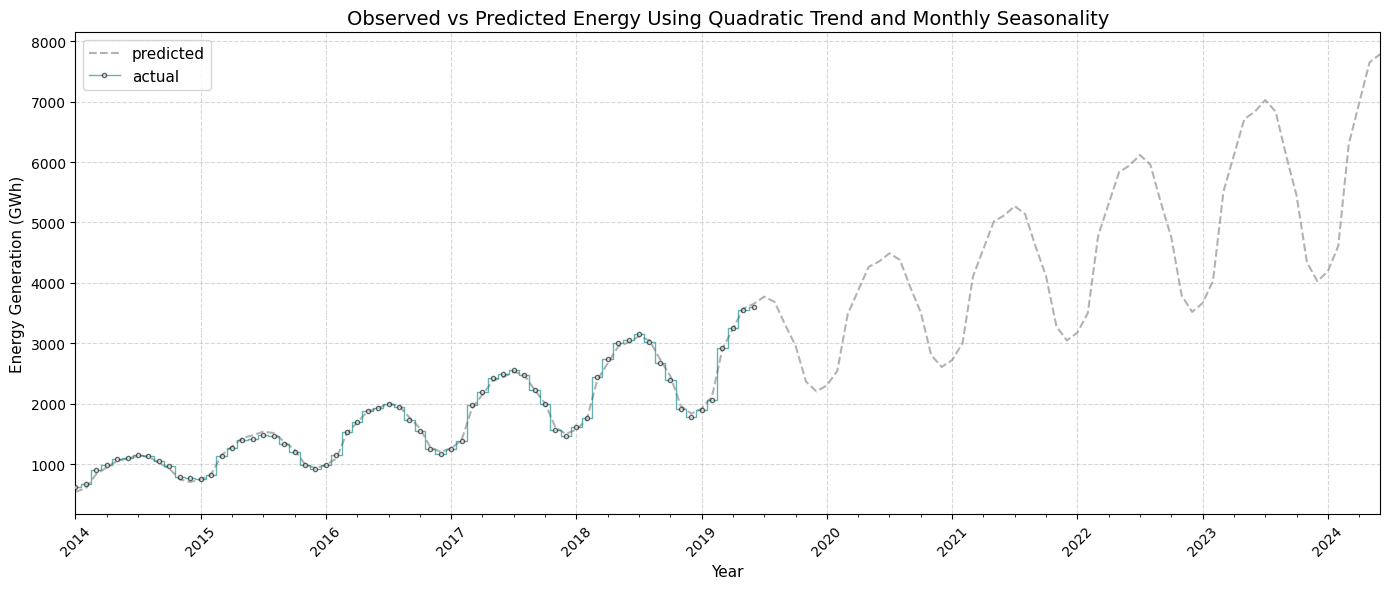

In [110]:
# training.plot(label="training", **actual_options)
# pred.plot(label="prediction", **pred_options)
# decorate(ylabel="GWh")

fig, ax = plt.subplots(figsize=(14, 6))

pred.plot(label="predicted",
          **model_options
          )

training.plot(label="actual",
              **line_options
              )

style_ax(ax,
         title="Observed vs Predicted Energy Using Quadratic Trend and Monthly Seasonality",
         xlabel="Year",
         ylabel="Energy Generation (GWh)",
         )


plt.tight_layout()
plt.show()

Observation:
  - The retrodictions fit the training data well and the predictions seem plausible
  


Now let's see if they turned out to be accurate.

Here are the predictions along with the test data.

In [111]:
forecast = pred[test.index]
forecast.tail()

2024-02-29    4610.340635
2024-03-31    6291.674766
2024-04-30    6973.926758
2024-05-31    7650.630068
2024-06-30    7785.376378
Freq: ME, dtype: float64

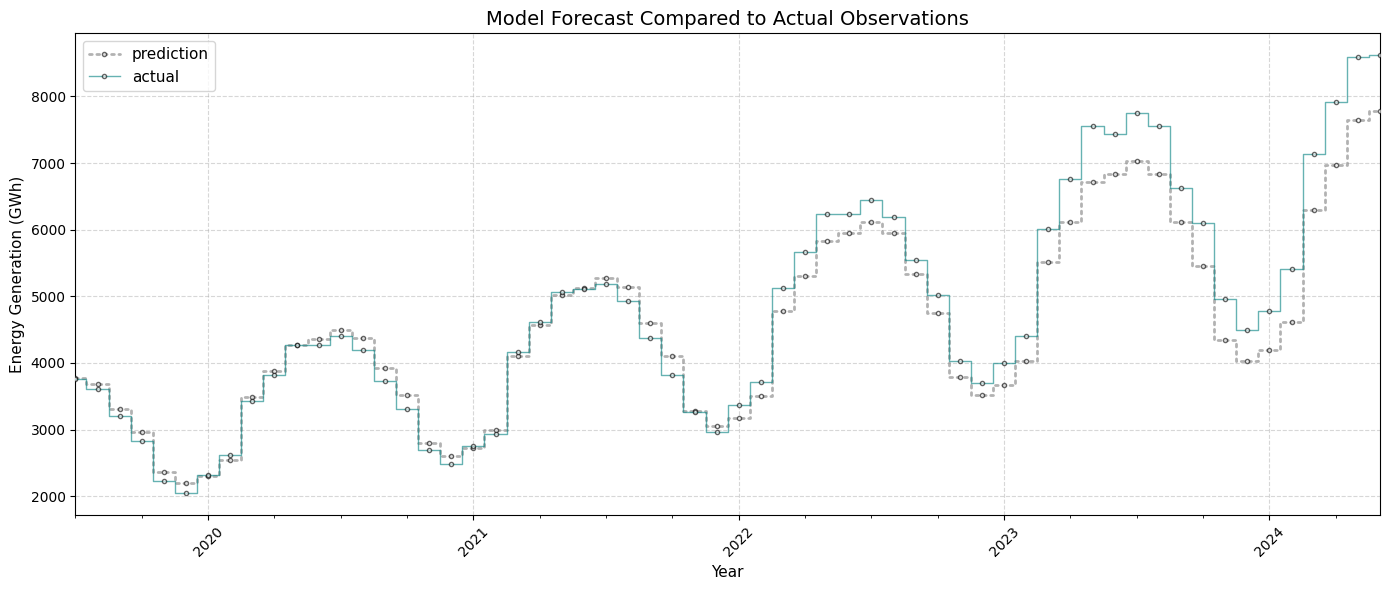

In [112]:
fig, ax = plt.subplots(figsize=(14, 6))

forecast.plot(label="prediction",
          **pred_options
          )

test.plot(label="actual",
              **line_options
              )

style_ax(ax,
         title="Model Forecast Compared to Actual Observations",
         xlabel="Year",
         ylabel="Energy Generation (GWh)",
         )


plt.tight_layout()
plt.show()

Observations:
  - For the first three years, the predictions are very good.
  - After that, it looks like actual growth exceeded expectations.
  - In this example - `solar_data`, seasonal decomposition worked well for modeling and predicting solar production,
    - but in the previous example  - `nuclear_data`,, it was not very effective for nuclear production.
    
In the next section, we'll try a different approach, autoregression.

In the next section, we'll try a different approach, autoregression.

## 7.  Autoregression

Auto-Regression (AR) opens a powerful way to model time series based on past values of the series itself.


Idea 1: The future will be like the past.

* The value of a variable at time $t$ depends on its own past values - i.e., history matters.


  $$
  y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \epsilon_t
  $$




Idea 2: Temporal Dependence Can Be Quantified

* Use lags to capture how strongly the past influences the present.
* Choose optimal lag $p$ with ACF, PACF, or model criteria (AIC, BIC).


Idea 3: The Past’s Influence Decays with Time

* Recent values (e.g., $y_{t-1}$) often have stronger impact than older ones (e.g., $y_{t-5}$).
* This is reflected in smaller AR coefficients for distant lags.

Idea 4: The Process Must Be Stationary

* AR assumes no long-term drift or changing variance.
* If the time series isn't stationary - difference it (e.g., with $y_t - y_{t-1}$ or $y_t - y_{t-12}$).


Idea 5: Autoregression Is a Linear Model (by default)

* Standard AR assumes the relationship between past and current values is linear.
* You can extend this to nonlinear AR models (e.g., ARNN, threshold AR).

Idea 6: Prediction = Using Past Values to Forecast

* One-step and multi-step forecasts are generated by iteratively feeding past predictions back into the model.

Idea 7: Residuals Should Be Random

* If the model captures all temporal structure, the residuals (errors) should be white noise.
* If not, the model is missing something (e.g., seasonal effects, nonlinearity).

### 7.1 Autoregression - Idea 1 :
> The first idea of autoregression is that the future will be like the past.

For example, in the time series we've looked at so far, there is a clear annual cycle.
So if you are asked to make a prediction for next June, a good starting place would be last June.

To see how well that might work, let's go back to `nuclear_data`, which contains monthly electricity production from nuclear generators, and compute differences between the same month in successive years, which are called "year-over-year" differences.


In [113]:
nuclear_data.head(2)

2001-01-31    68707.0
2001-02-28    61272.0
Freq: ME, Name: nuclear, dtype: float64

In [114]:
diff = (nuclear_data - nuclear_data.shift(12)).dropna()
diff

2002-01-31    2219.0
2002-02-28     386.0
2002-03-31     900.0
2002-04-30    2434.0
2002-05-31    1520.0
               ...  
2024-02-29    3777.0
2024-03-31     526.0
2024-04-30     664.0
2024-05-31    3500.0
2024-06-30    3227.0
Freq: ME, Name: nuclear, Length: 270, dtype: float64

`nuclear_data.shift(12)` -  shifts the `nuclear_data` series *12 time steps back*.

`nuclear_data - nuclear.shift(12)` - calculates the *difference between the current value and the value one year ago* for each time point.


We’re creating a new series:

$$
\text{diff}_t = \text{nuclear}_t - \text{nuclear}_{t-12}
$$

This transformation is helpful to:

* *Remove seasonal patterns* (especially annual cycles in monthly data),
* *Stationarize* the data - a key requirement for many time series models like ARIMA,
* *Highlight changes* from the same month in the previous year (e.g., “how much more or less nuclear output than last year?”).


`diff` tells you - "How much did this month’s nuclear output differ from the same month last year?"

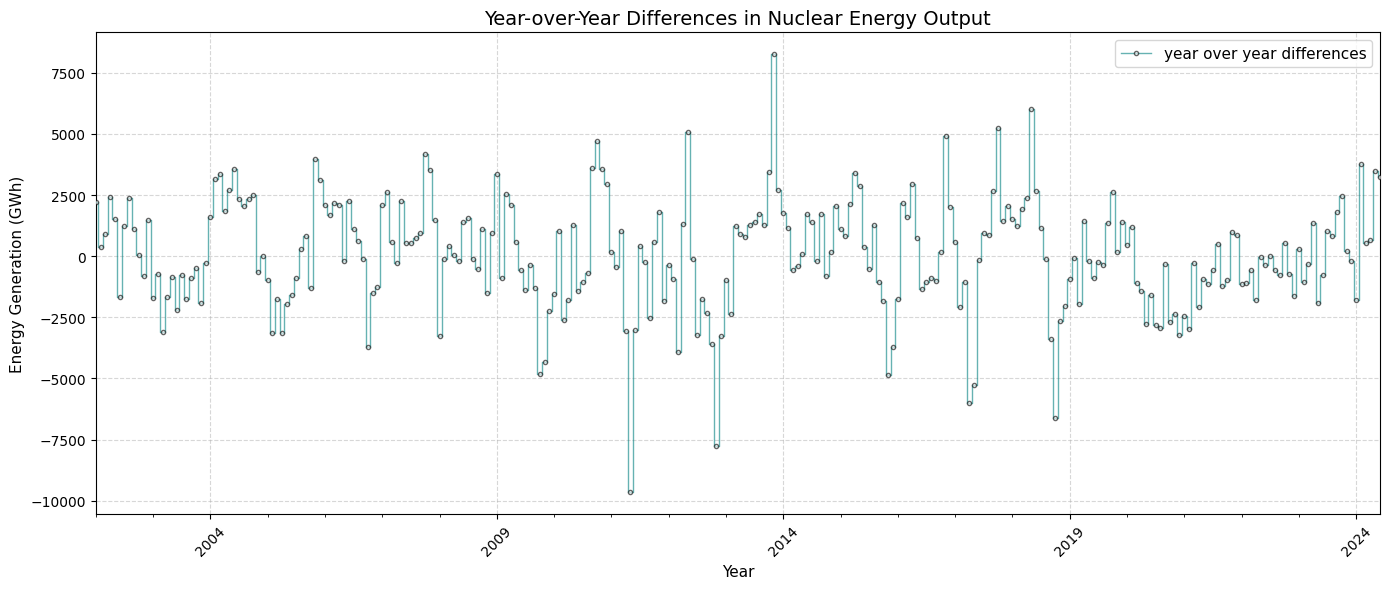

In [115]:
fig, ax = plt.subplots(figsize=(14, 6))

diff.plot(label="year over year differences",
          **line_options
          )


style_ax(ax,
         title="Year-over-Year Differences in Nuclear Energy Output",
         xlabel="Year",
         ylabel="Energy Generation (GWh)",
         )


plt.tight_layout()
plt.show()

Obsrvations:

  - The magnitudes of these differences are substantially smaller than the magnitudes of the original series.
    -  which suggests the second idea of autoregression, which is that it might be easier to predict these differences, rather than the original values.


### 7.2. Auto-Regression -  Idea 2:
  
  > It's often easier to model the differences (changes) rather than the levels.

Toward that end, let's see if there are correlations between successive elements in the series of differences.

If so, we could use those correlations to predict future values based on previous values.

Let's start by making a `DataFrame`, putting the differences in the first column and putting  the same differences -- shifted by 1, 2, and 3 months -- into successive columns.

These columns are named `lag1`, `lag2`, and `lag3`, because the series they contain have been *lagged* or delayed.

In [116]:
df_ar = pd.DataFrame({"diff": diff})
df_ar.tail()

diff
2024-02-29  3777.0
2024-03-31   526.0
2024-04-30   664.0
2024-05-31  3500.0
2024-06-30  3227.0

In [117]:
adf = df_ar.copy()
adf.tail()

diff
2024-02-29  3777.0
2024-03-31   526.0
2024-04-30   664.0
2024-05-31  3500.0
2024-06-30  3227.0

`shift(1)` -  shifts the column down by 1 row.

- So each value at time t gets the value from time t - 1 (the previous row in the index).

In [118]:
lag = 1
adf[f"lag{lag}"] = diff.shift(lag)

adf.head()

diff    lag1
2002-01-31  2219.0     NaN
2002-02-28   386.0  2219.0
2002-03-31   900.0   386.0
2002-04-30  2434.0   900.0
2002-05-31  1520.0  2434.0

In [119]:
for lag in [1, 2, 3]:
    df_ar[f"lag{lag}"] = diff.shift(lag)
df_ar.head()

diff    lag1    lag2    lag3
2002-01-31  2219.0     NaN     NaN     NaN
2002-02-28   386.0  2219.0     NaN     NaN
2002-03-31   900.0   386.0  2219.0     NaN
2002-04-30  2434.0   900.0   386.0  2219.0
2002-05-31  1520.0  2434.0   900.0   386.0

In [120]:
df_ar = df_ar.dropna()
df_ar.head()

diff    lag1    lag2    lag3
2002-04-30  2434.0   900.0   386.0  2219.0
2002-05-31  1520.0  2434.0   900.0   386.0
2002-06-30 -1651.0  1520.0  2434.0   900.0
2002-07-31  1255.0 -1651.0  1520.0  2434.0
2002-08-31  2389.0  1255.0 -1651.0  1520.0

Here are the correlations between these columns.

* The correlation of a time series with *its own past values*.

In [121]:
df_ar.corr()[["diff"]]

diff
diff  1.000000
lag1  0.562212
lag2  0.292454
lag3  0.222228

- These correlations are called lagged correlations or *autocorrelations*
  -  the prefix "auto" indicates that we're taking the correlation of the series with itself.


 - As a special case, the correlation between `diff` and `lag1` is called *serial correlation* because it is the correlation between successive elements in the series.

- These correlation are strong enough to suggest that they should help with prediction, so let's put them into a multiple regression.




* A correlation of 0.56 at lag 1 suggests that the immediate past (`diff[t-1]`) *contains predictive information* about the present (`diff[t]`).
* Lower correlations for lag2 and lag3 show that older lags contribute *less*.

Insight:

> The autocorrelation structure we've uncovered *justifies building an autoregressive model*.
  - If past changes correlate with current changes, use them to predict.



The following function uses the columns from the `DataFrame` to make a Patsy formula with the first column as the response variable and the other columns as explanatory variables.

In [122]:
def make_reg_eqn(df, exclude=None):
    """
    Constructs a Patsy-style regression formula string from a DataFrame.

    The first column is treated as the response variable (y),
    and the remaining columns are treated as predictors (x),
    unless specified otherwise via the `exclude` parameter.

    exclude : list, optional
        List of column names to exclude from predictors.

    Returns:
    --------
    str
        A regression formula string, e.g., 'y ~ x1 + x2 + x3'
    """
    if df.shape[1] < 2:
        raise ValueError("DataFrame must have at least two columns.")

    y = df.columns[0]
    predictors = list(df.columns[1:])

    if exclude:
        predictors = [col for col in predictors if col not in exclude]

    if not predictors:
        raise ValueError("No predictors left after applying exclusion list.")

    x_part = " + ".join(predictors)
    return f"{y} ~ {x_part}"


In [123]:
adf.head()

diff    lag1
2002-01-31  2219.0     NaN
2002-02-28   386.0  2219.0
2002-03-31   900.0   386.0
2002-04-30  2434.0   900.0
2002-05-31  1520.0  2434.0

In [124]:
make_reg_eqn(adf)

'diff ~ lag1'

Here are the results of a linear model that predicts the next value in a sequence based on the previous three values.

In [125]:
formula = make_reg_eqn(df_ar)
formula

'diff ~ lag1 + lag2 + lag3'

In [126]:
model = smf.ols(formula,
                data=df_ar
                ).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     42.00
Date:                Fri, 06 Jun 2025   Prob (F-statistic):           3.30e-22
Time:                        03:04:10   Log-Likelihood:                -2388.8
No. Observations:                 267   AIC:                             4786.
Df Residuals:                     263   BIC:                             4800.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.2674    114.674      0.212      0.8

Observations:

* Only the 1‐period lag is highly significant; lags 2 and 3 add little.
* Model explains \~32 % of variance (R² = 0.324).
* Residuals deviate from normality, but show minimal autocorrelation (Durbin–Watson ≈ 2).

Conclusions

* A simple AR(1) captures most of the autoregressive effect.

Now we can use the `predict` method to generate predictions for the past values in the series.
Here's what these retrodictions look like compared to the data.

In [127]:
pred_ar = model.predict(df_ar)
pred_ar.head()

2002-04-30     743.101591
2002-05-31    1405.316251
2002-06-30     784.306393
2002-07-31    -829.426829
2002-08-31    1063.960748
dtype: float64

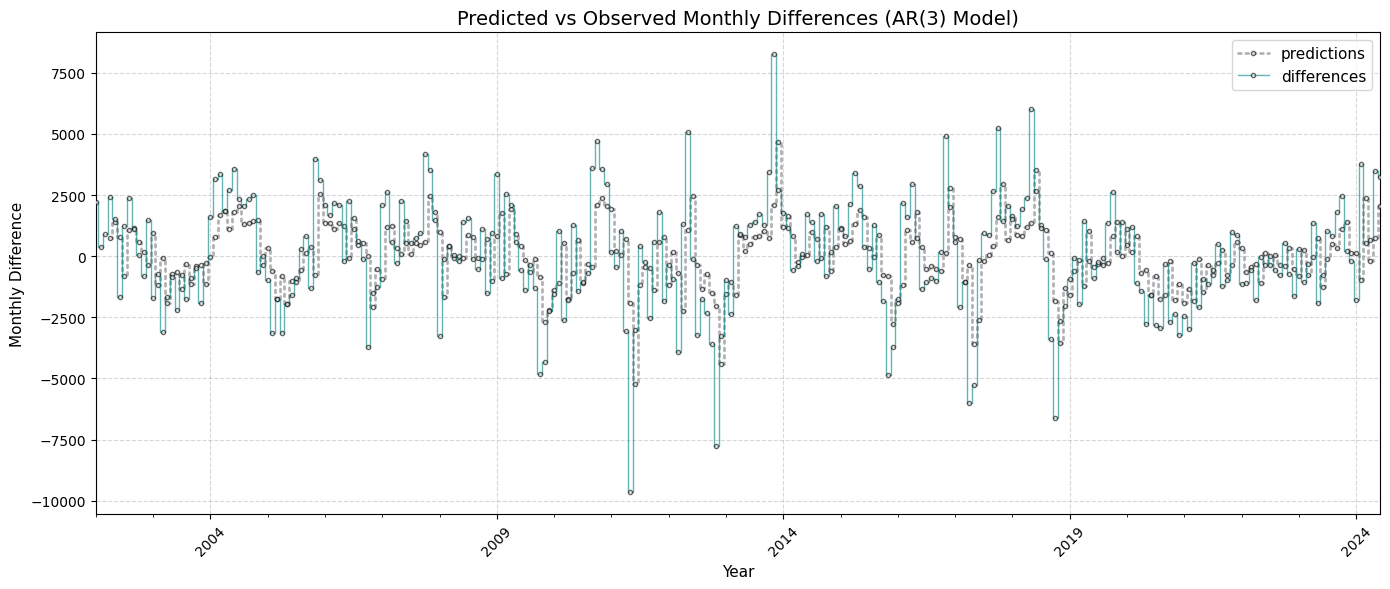

In [128]:
fig, ax = plt.subplots(figsize=(14, 6))

pred_ar.plot(label="predictions",
          **pred_options
          )

diff.plot(label="differences",
              **line_options
              )

style_ax(ax,
         title="Predicted vs Observed Monthly Differences (AR(3) Model)",
         xlabel="Year",
         ylabel="Monthly Difference",
         )


plt.tight_layout()
plt.show()



The predictions are good in some places, but the $R^2$ value is only about 0.324, so there is room for improvement.

In [129]:
resid_ar = (diff - pred_ar).dropna()
R2 = 1 - resid_ar.var() / diff.var()
R2

0.3190252265690784

The only time to prefer `model.rsquared`:

* When you're evaluating *in-sample model fit*, without missing values, using the exact data the model was trained on.


Manual $R^2$ is more flexible and often *more accurate* for *evaluating actual predictive performance* - especially if:

* You use `dropna()`,
* You're forecasting beyond the training set,
* Or you're comparing multiple models consistently.

Manual $R^2$ formula mathematically:

$$
R^2 = 1 - \frac{\text{Var}(\text{residuals})}{\text{Var}(\text{true values})}
$$

This assumes:

* Both vectors (`diff` and `pred_ar`) are aligned in time,
* We're computing sample variance.

With `sklearn.metrics.r2_score()` we can use:

```python
from sklearn.metrics import r2_score
r2_score(true_diff, base_pred_aligned)
```

This computes:

$$
R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}
$$

This is the *standard definition of $R^2$*, based on:

* Sum of squared errors (SSE)
* Total sum of squares (TSS)



$$
\text{Var}(y) = \frac{1}{n} \sum (y_i - \bar{y})^2 \quad \Rightarrow \quad \text{manual R²} \approx \text{sklearn R²}
$$

The only difference:

* `var()` uses *sample variance* (divided by $n-1$),
* `r2_score()` uses *TSS* (divided by $n$, effectively) - but the ratio still gives the same $R^2$ in practice.

> *Manual formula* and `r2_score()` from scikit-learn are mathematically equivalent for aligned time series, and produce essentially the *same $R^2$*
 value.

 The sklearn version is more general and better for external predictions or test sets.


One way to improve the predictions is to compute the residuals from this model and use another model to predict the residuals - which is the third idea of autoregression.


### 7.3. Auto correlation Idea 7 : Two-stage residual modeling approach

Residuals Should Be Random -  is exactly where we check for autocorrelation after our first model is fit.

In other words:
  1. Fit our main AR, trend/season, regression, etc.
  2. Look at the residuals. If they still exhibit autocorrelation (i.e. “they aren’t white noise”), we go back and fit an additional AR (or ARMA/GARCH, etc.) to those residuals.
  
That two-stage approach-“first model the big-picture structure, then model whatever serial dependence is left over in the errors”-is exactly what Idea 7 is warning we have to do if residuals are not yet random.

In [130]:
df_ar_clean = df_ar.dropna()

# Base AR model: diff ~ lag1 + lag2 + lag3
X1 = sm.add_constant(df_ar_clean[['lag1', 'lag2', 'lag3']])
y1 = df_ar_clean['diff']
model1 = sm.OLS(y1, X1).fit()
base_pred = model1.predict(X1)
resid1 = y1 - base_pred

Model the residuals

In [131]:
# Create lag features for residuals
resid_df = pd.DataFrame({
    "resid": resid1,
    "r_lag1": resid1.shift(1),
    "r_lag2": resid1.shift(2),
    "r_lag3": resid1.shift(3)
}).dropna()

# Fit residual model
X2 = sm.add_constant(resid_df[['r_lag1', 'r_lag2', 'r_lag3']])
y2 = resid_df['resid']
model2 = sm.OLS(y2, X2).fit()
resid_pred = model2.predict(X2)

Combine predictions

In [132]:
# Align base predictions to residual index
base_pred_aligned = base_pred.loc[resid_df.index]

# Final prediction = base model + predicted residuals
final_pred = base_pred_aligned + resid_pred

# True values for evaluation
true_diff = df_ar_clean.loc[resid_df.index, 'diff']


In [133]:
true_diff

2002-07-31    1255.0
2002-08-31    2389.0
2002-09-30    1103.0
2002-10-31      32.0
2002-11-30    -822.0
               ...  
2024-02-29    3777.0
2024-03-31     526.0
2024-04-30     664.0
2024-05-31    3500.0
2024-06-30    3227.0
Freq: ME, Name: diff, Length: 264, dtype: float64

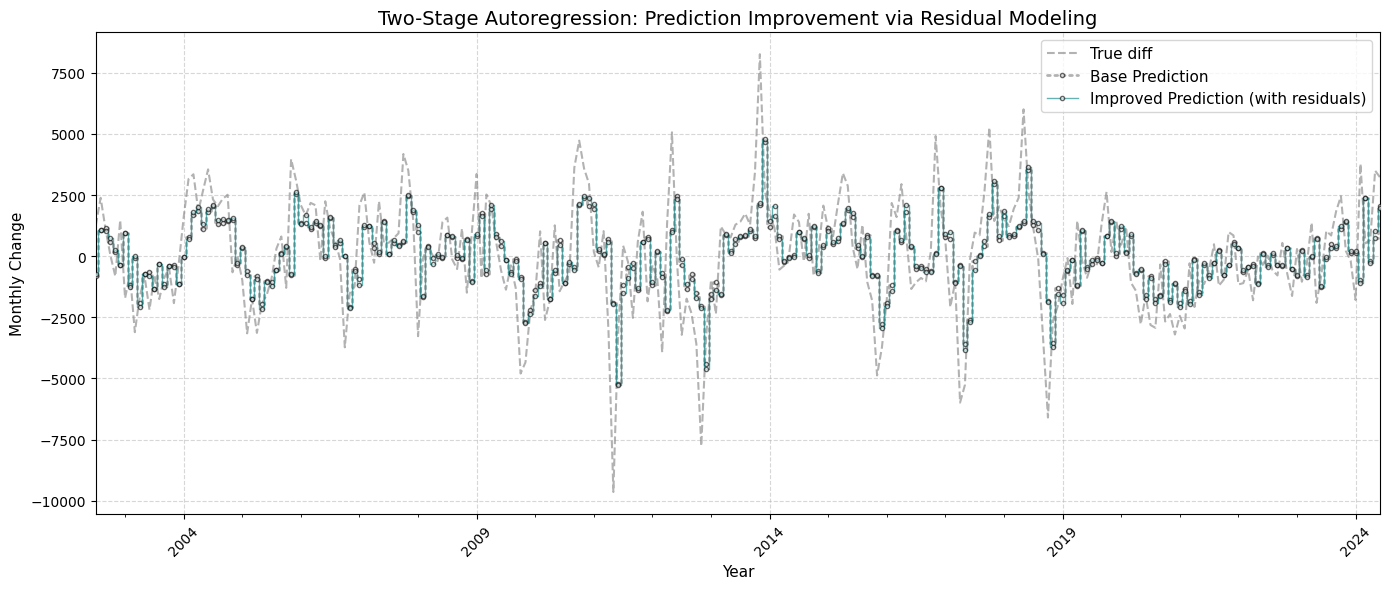

Base model R2: 0.3250296475136121
Improved model R2: 0.3280657558038036


In [134]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6))

true_diff.plot(label="True diff",
              **model_options
              )

base_pred_aligned.plot(label="Base Prediction",
          **pred_options
          )

final_pred.plot(label="Improved Prediction (with residuals)",
              **line_options
              )

style_ax(ax,
         title="Two-Stage Autoregression: Prediction Improvement via Residual Modeling",
         xlabel="Year",
         ylabel="Monthly Change",
         )


plt.tight_layout()
plt.show()

print("Base model R2:", r2_score(true_diff, base_pred_aligned))
print("Improved model R2:", r2_score(true_diff, final_pred))

Insight:
  > The two-stage autoregressive model, which adds a second regression layer on the residuals, yields a small improvement in predictive accuracy (R² increase from 0.325 to 0.328).
  
This suggests that the residuals still contained some minor autocorrelation not captured by the base model — though most of the structure was already explained in the first stage.

## 8. Moving Average

It's June 2019,  make a prediction for June 2020.

  * First guess : this year's value will be repeated next year.

It's May 2020,  revise your prediction for June 2020.

  * We could use the results from the last three months,
  * and the autocorrelation model from the previous section,
  to predict the year-over-year difference.

Finally, suppose you check the predictions for the last few months, and see that they have been consistently too low.
That suggests that the prediction for next month might also be too low, so you could revise it upward.

> The underlying assumption is that recent prediction errors predict future prediction errors.

To see whether they do, we can make a `DataFrame` with the residuals from the autoregression model in the first column, and lagged versions of the residuals in the other columns.

For this example, we'll use lags of 1 and 6 months.

A classic setup for exploring *moving average (MA) behavior* in residuals.


```python
df_ma = pd.DataFrame({"resid": resid_ar})

for lag in [1, 6]:
    df_ma[f"lag{lag}"] = resid_ar.shift(lag)

df_ma = df_ma.dropna()
```

This creates a new DataFrame where:

* Column `resid` = current residuals (errors from the base model).
* Columns `lag1` and `lag6` = residuals from 1 and 6 months earlier, respectively.



1. Lag 1:

  * Captures short-term error autocorrelation.
  * If `resid[t]` is correlated with `resid[t-1]`, this suggests a structure the base model missed - a key property in MA(1) or ARMA models.

2. Lag 6:

  * Captures potential *semi-annual (6-month)* cyclical behavior.
  * Useful if the process has mid-year effects (e.g., seasonal cycles not fully captured earlier).
  * Also used to *test* whether longer-memory error effects are present.



You're preparing to test whether:

$$
\text{resid}_t \sim \text{resid}_{t-1} + \text{resid}_{t-6}
$$

Which is analogous to fitting a *moving average model*:

* If residuals depend on past residuals - MA structure.
* If significant - previous models left autocorrelated errors $\implies $ room for improvement.

In [135]:
df_ma = pd.DataFrame({"resid": resid_ar})

for lag in [1, 6]:
    df_ma[f"lag{lag}"] = resid_ar.shift(lag)

df_ma = df_ma.dropna()
df_ma.head()

resid         lag1         lag6
2002-10-31  -548.988946   -34.784374  1690.898409
2002-11-30 -1009.896078  -548.988946   114.683749
2002-12-31  1820.112406 -1009.896078 -2435.306393
2003-01-31 -2679.067041  1820.112406  2084.426829
2003-02-28   480.708950 -2679.067041  1325.039252

We can use `ols` to make an autoregression model for the residuals.

- This part of the model is called a `moving average` because it reduces variability in the predictions in a way that's analogous to the effect of a moving average.
  - I don't find that term particularly helpful, but it is conventional.

Anyway, here's a summary of the autoregression model for the residuals.

In [136]:
formula = make_reg_eqn(df_ma)
print(formula)
model = smf.ols(formula,
                data=df_ma).fit()
print(model.summary())

resid ~ lag1 + lag6
                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     3.267
Date:                Fri, 06 Jun 2025   Prob (F-statistic):             0.0397
Time:                        03:04:13   Log-Likelihood:                -2332.7
No. Observations:                 261   AIC:                             4671.
Df Residuals:                     258   BIC:                             4682.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.0016    114.697

Insights:
  - The $R^2$ is quite small, so it looks like this part of the model won't help very much.
  - But the p-value for the 6-month lag is small, which suggests that it contributes more information than we'd expect by chance.

Now we can use the model to generate retrodictions for the residuals.

In [137]:
pred_ma = model.predict(df_ma)
pred_ma

2002-10-31   -283.273243
2002-11-30    -33.039442
2002-12-31    372.312960
2003-01-31   -343.301499
2003-02-28   -228.769157
                 ...    
2024-02-29    -72.088819
2024-03-31   -242.591426
2024-04-30   -229.436609
2024-05-31    172.777451
2024-06-30     39.465347
Length: 261, dtype: float64

Then, to generate retrodictions for the year-over-year differences, we add the adjustment from the second model to the retrodictions from the first.

In [138]:
pred_diff = pred_ar + pred_ma
pred_diff

2002-04-30            NaN
2002-05-31            NaN
2002-06-30            NaN
2002-07-31            NaN
2002-08-31            NaN
                 ...     
2024-02-29   -1054.390540
2024-03-31    2132.586145
2024-04-30    -424.274037
2024-05-31     925.010412
2024-06-30    2103.879249
Length: 267, dtype: float64

The $R^2$ value for the sum of the two models is about 0.332, which is just a little better than the result without the moving average adjustment (0.319).

In [139]:
resid_ma = (diff - pred_diff).dropna()
R2 = 1 - resid_ma.var() / diff.var()
R2

0.33151010013912285

Next we'll use these year-over-year differences to generate retrodictions for the original values.

## 9. Retrodiction with Autoregression

To generate retrodictions, we'll start by putting the year-over-year differences in a `Series` that's aligned with the index of the original.

A *retrodiction* is the opposite of a prediction.

* Prediction: Estimating *future* values based on a model.
* Retrodiction: Estimating *past* or *known* values using a model -  especially when:

  * Data was missing,
  * You want to test the model's fit to historical data,
  * Or you're reconstructing what should have happened based on current understanding.

In Time Series Context:

If the model covers both past and future time points, then:

* The model’s output for *dates already in the training data* = *retrodictions*
* The model’s output for *future dates* = *predictions*

Why use Retrodictions?

1. Compare retrodicted values to known observations — check accuracy.
2. Recover values for time points with missing or unreliable data.
3. Test if a model built today would explain known past behavior.



We have trained a model using:

* A *quadratic trend*, and
* A *monthly seasonal pattern*.

Then:

* We use it to *retrodict* past values (to see how well the model fits),
* And to *predict* future values (to forecast upcoming trends).

In [140]:
pred_diff = pd.Series(pred_diff,
                      index=nuclear_data.index
                      )

Using `isna` to check for `NaN` values, we find that the first 21 elements of the new `Series` are missing.

In [141]:
n_missing = pred_diff.isna().sum()
n_missing

np.int64(21)

That's because we shifted the `Series` by 12 months to compute year-over-year differences, then we shifted the differences 3 months for the first autoregression model, and we shifted the residuals of the first model by 6 months for the second model.
Each time we shift a `Series` like this, we lose a few values at the beginning, and the sum of these shifts is 21.

So before we can generate retrodictions, we have to prime the pump by copying the first 21 elements from the original into a new `Series`.

In [142]:
pred_series = pd.Series(index=nuclear_data.index, dtype=float)
pred_series.iloc[:n_missing] = nuclear_data.iloc[:n_missing]

Now we can run the following loop, which fills in the elements from index 21 (which is the 22nd element) to the end.
Each element is the sum of the value from the previous year and the predicted year-over-year difference.

In [143]:
for i in range(n_missing, len(pred_series)):
    pred_series.iloc[i] = pred_series.iloc[i - 12] + pred_diff.iloc[i]

Now we'll replace the elements we copied with `NaN` so we don't get credit for "predicting" the first 21 values perfectly.

In [144]:
pred_series[:n_missing] = np.nan

Here's what the retrodictions look like compared to the original.

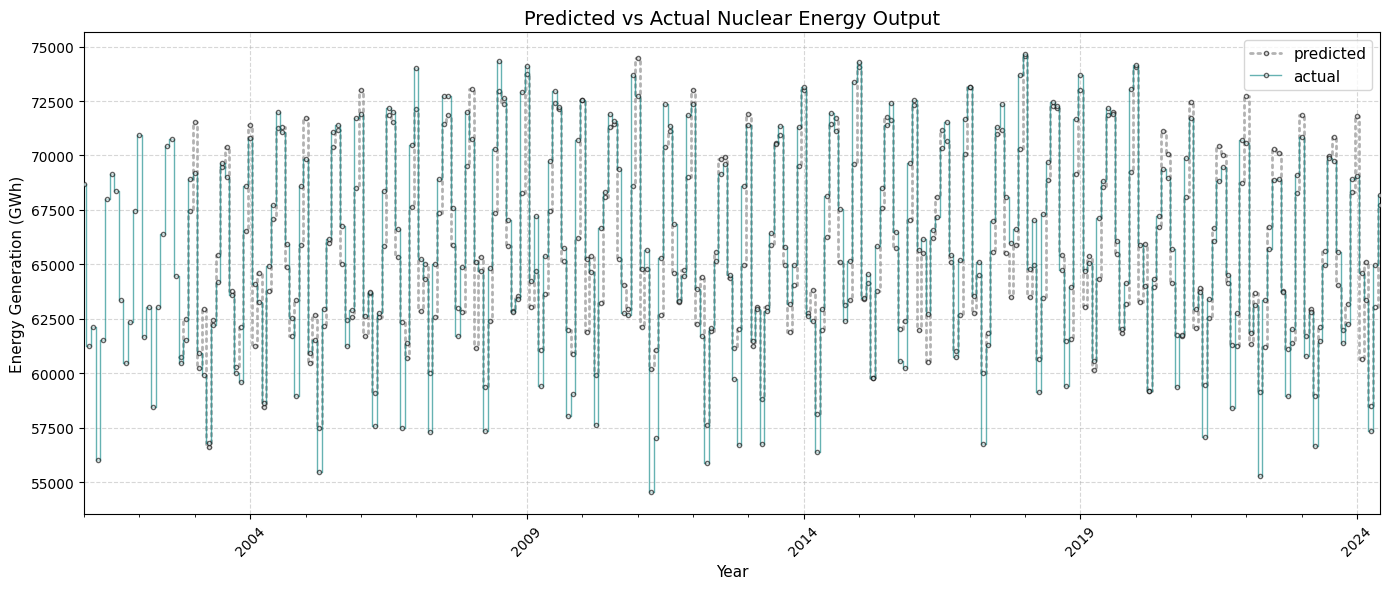

In [145]:
fig, ax = plt.subplots(figsize=(14, 6))

pred_series.plot(label="predicted",
          **pred_options
          )

nuclear_data.plot(label="actual",
              **line_options
              )

style_ax(ax,
         title="Predicted vs Actual Nuclear Energy Output",
         xlabel="Year",
         ylabel="Energy Generation (GWh)",
         )


plt.tight_layout()
plt.show()


They look pretty good, and the $R^2$ value is about 0.86.

In [146]:
resid = (nuclear_data - pred_series).dropna()
R2 = 1 - resid.var() / nuclear_data.var()
R2

0.8586566911201015

The model we used to compute these retrodictions is called SARIMA, which is one of a family of models called ARIMA.
Each part of these acronyms refers to an element of the model.

* **S** stands for seasonal, because the first step was to compute differences between values separated by one seasonal period.

* **AR** stands for autoregression, which we used to model lagged correlations in the differences.

* **I** stands for integrated, because the iterative process we used to compute `pred_series` is analogous to integration in calculus.

* **MA** stands for moving average, which is the conventional name for the second autoregression model we ran with the residuals from the first.

ARIMA models are powerful and versatile tools for modeling time series data.

## 10. ARIMA - Autoregressive Integrated Moving Average


Formulation: `ARIMA(p, d, q)` combines three parts:

  1. AR(p): Regresses the series on its own `p` most recent lags.
  2. I(d): Differencing order `d` to remove non‐stationarity (e.g., if d = 1, you model $\Delta y_t = y_t − y_{t-1}$).
  3. MA(q): Models the error (residual) at time `t` as a linear combination of the `q` most recent error terms.

When to use: A non‐seasonal time series that needs differencing to become stationary, and where you suspect both autoregressive (memory) and moving‐average (shock) components.

General form:

  $$
    \Delta^d yₜ \;=\; \phi₁\,\Delta^d y_{t-1} + \dots + \phi_p\,\Delta^d y_{t-p}
      \;+\; \theta₁\,\varepsilon_{t-1} + \dots + \theta_q\,\varepsilon_{t-q} \;+\; \varepsilon_t.
  $$



**SARIMA (Seasonal ARIMA)**

Formulation: `SARIMA(p, d, q) x (P, D, Q, s)` adds a seasonal layer on top of ARIMA:

  1. (p, d, q): Exactly as above for the non‐seasonal part.
  2. (P, D, Q, s): Seasonal orders and seasonal period s (e.g., s = 12 for monthly data with yearly seasonality):

     * AR(P): Autoregressive part at seasonal lags (lags s, 2s, …, Ps).
     * D: Seasonal difference order (e.g., D = 1 means Δ₁₂yₜ = yₜ − yₜ₋₁₂).
     * MA(Q): Moving‐average part at seasonal lags (errors at t − s, t − 2s, …, t − Qs).

When to use: A time series with clear repeating patterns (e.g., monthly sales that go up every summer) that also needs non‐seasonal differencing and AR/MA terms.

General form (in backshift operator B):

  $$
    \Phi_P(B^s)\,\phi_p(B)\,(1 - B)^d\,(1 - B^s)^D \,yₜ
      = \Theta_Q(B^s)\,\theta_q(B)\,\varepsilon_t,
  $$

  where

  * $\phi_p(B) = 1 - \phi₁B - \dots - \phi_pB^p$ (non‐seasonal AR)
  * $\Phi_P(B^s) = 1 - \Phi₁B^s - \dots - \Phi_PB^{Ps}$ (seasonal AR)
  * $\theta_q(B) = 1 + \theta₁B + \dots + \theta_qB^q$ (non‐seasonal MA)
  * $\Theta_Q(B^s) = 1 + \Theta₁B^s + \dots + \Theta_QB^{Qs}$ (seasonal MA)



Key Differences & When to Choose Which

1. Seasonality

   * ARIMA: Does *not* explicitly model repeating seasonal swings; any seasonality must be removed by differencing (e.g., set d = 12 in monthly data).
   * SARIMA: Explicitly captures seasonal patterns at lag s (e.g., month 12), so you fit both seasonal AR and seasonal MA terms (P and Q) and a seasonal difference (D).

2. Model Complexity vs. Fit

   * ARIMA: Fewer parameters, simpler if data have no strong seasonality.
   * SARIMA: More parameters (p + q + P + Q), slightly harder to tune, but usually fits seasonal data much better.

3. Diagnostic Workflow

   * ARIMA:

     1. Plot ACF/PACF of original series; if ACF has a big spike at lag 12, that suggests seasonality.
     2. Difference non‐seasonally (d) until series is roughly stationary.
     3. Use AIC/BIC or inspect residual ACF to choose p and q.
   
   * SARIMA:

     1. Check seasonal ACF/PACF (e.g., ACF spikes at lags 12, 24 - seasonality period = 12).
     2. Difference at lag s (D = 1 if needed), then difference again non‐seasonally (d).
     3. Choose (p, q) from ACF/PACF of the twice‐differenced series.
     4. Choose (P, Q) from ACF/PACF at seasonal lags (multiples of s).
     5. Validate via residual diagnostics (Ljung–Box on residuals, check no leftover seasonality).

StatsModel provides a library called `tsa`, which stands for "time series analysis" -- it includes a function called `ARIMA` that fits ARIMA models and generates forecasts.

To fit the SARIMA model we developed in the previous sections, we'll call this function with two tuples as arguments: `order` and `seasonal_order`.
Here are the values in `order` that correspond to the model we used in the previous sections.

In [147]:
order = ([1, 2, 3], 0, [1, 6])

The values in `order` indicate:

* Which lags should be included in the AR model -- in this example it's the first three.

* How many times it should compute differences between successive elements -- in this example it's 0 because we computed a seasonal difference instead, and we'll get to that in a minute.

* Which lags should be included in the MA model -- in this example it's the first and sixth.

Now here are the values in `seasonal_order`.

In [148]:
seasonal_order = (0, 1, 0, 12)

The first and third elements are 0, which means that this model does not include seasonal AR or seasonal MA.
The second element is 1, which means it computes seasonal differences -- and the last element is the seasonal period.

Here's how we use `ARIMA` to make and fit this model.

In [149]:
import statsmodels.tsa.api as tsa

model = tsa.ARIMA(nuclear_data,
                  order=order,
                  seasonal_order=seasonal_order
                  ).fit()
print(model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                nuclear   No. Observations:                  282
Model:             ARIMA(3, 0, [1, 6])x(0, 1, [], 12)   Log Likelihood               -2447.514
Date:                                Fri, 06 Jun 2025   AIC                           4907.028
Time:                                        03:04:16   BIC                           4928.618
Sample:                                    01-31-2001   HQIC                          4915.698
                                         - 06-30-2024                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0458      0.379      0.121      0.904      -0.697       0.788
ar.

The results include estimated coefficients for the three lags in the AR model, the two lags in the MA model, and `sigma2`, which is the variance of the residuals.

From `results_arima` we can extract `fittedvalues`, which contains the retrodictions.
For the same reason there were missing values at the beginning of the retrodictions we computed, there are incorrect values at the beginning of `fittedvalues`, which we'll drop.

In [150]:
fittedvalues = model.fittedvalues[n_missing:]
fittedvalues.head()

2002-10-31    60361.636533
2002-11-30    62238.006973
2002-12-31    67247.408166
2003-01-31    71314.856317
2003-02-28    60931.392829
Freq: ME, dtype: float64

The fitted values are similar to the ones we computed, but not exactly the same -- probably because `ARIMA` handles the initial conditions differently.

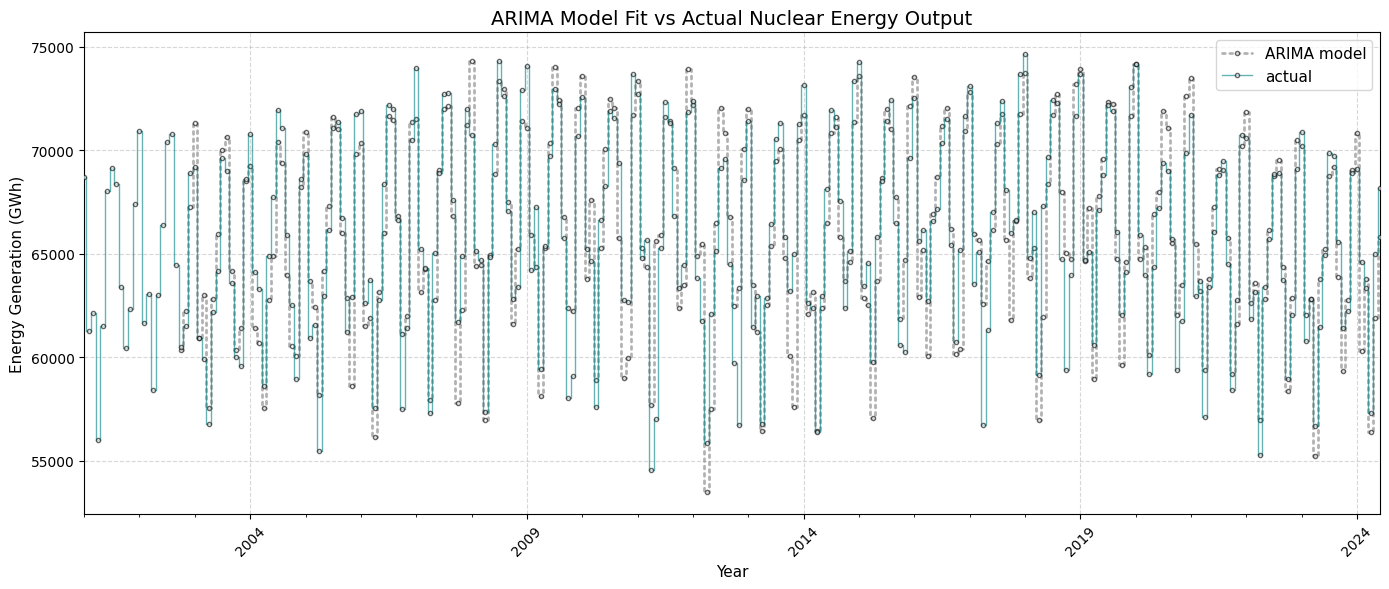

In [151]:
fig, ax = plt.subplots(figsize=(14, 6))

fittedvalues.plot(label="ARIMA model",
          **pred_options
          )

nuclear_data.plot(label="actual",
              **line_options
              )

style_ax(ax,
         title="ARIMA Model Fit vs Actual Nuclear Energy Output",
         xlabel="Year",
         ylabel="Energy Generation (GWh)",
         )


plt.tight_layout()
plt.show()


The $R^2$ value is also similar but not precisely the same.

In [152]:
resid = fittedvalues - nuclear_data
R2 = 1 - resid.var() / nuclear_data.var()
R2

0.8262717330822065

The `ARIMA` function makes it easy to experiment with different versions of the model.

As an exercise, try out different values in `order` and `seasonal_order` and see if you can  find a model with higher $R^2$.

#### Prediction with ARIMA

The object returned by `ARIMA` provides a method called `get_forecast` that generates predictions.
To demonstrate, we'll split the time series into a training and test set, and fit the same model to the training set.

In [153]:
training, test = split_series(nuclear_data)
model_train = tsa.ARIMA(training,
                  order=order,
                  seasonal_order=seasonal_order
                  ).fit()

We can use the result to generate a forecast for the test set.

In [154]:
forecast = model_train.get_forecast(steps=len(test))
forecast.predicted_mean.head()

2019-07-31    72327.690374
2019-08-31    72271.216447
2019-09-30    64830.839407
2019-10-31    59287.954267
2019-11-30    63997.088404
Freq: ME, Name: predicted_mean, dtype: float64

`.predicted_mean`   - Forecasted values (mean prediction)

`.conf_int()`     - 95% confidence intervals by default       

`.summary_frame()` - DataFrame with mean, lower/upper CI, etc.

`.se_mean`     -  Standard errors of predictions

The result is an object that contains an attribute called `forecast_mean` and a function that returns a confidence interval.

In [155]:
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
forecast_ci.columns = ["lower", "upper"]

We can plot the results like this and compare them to the actual time series.

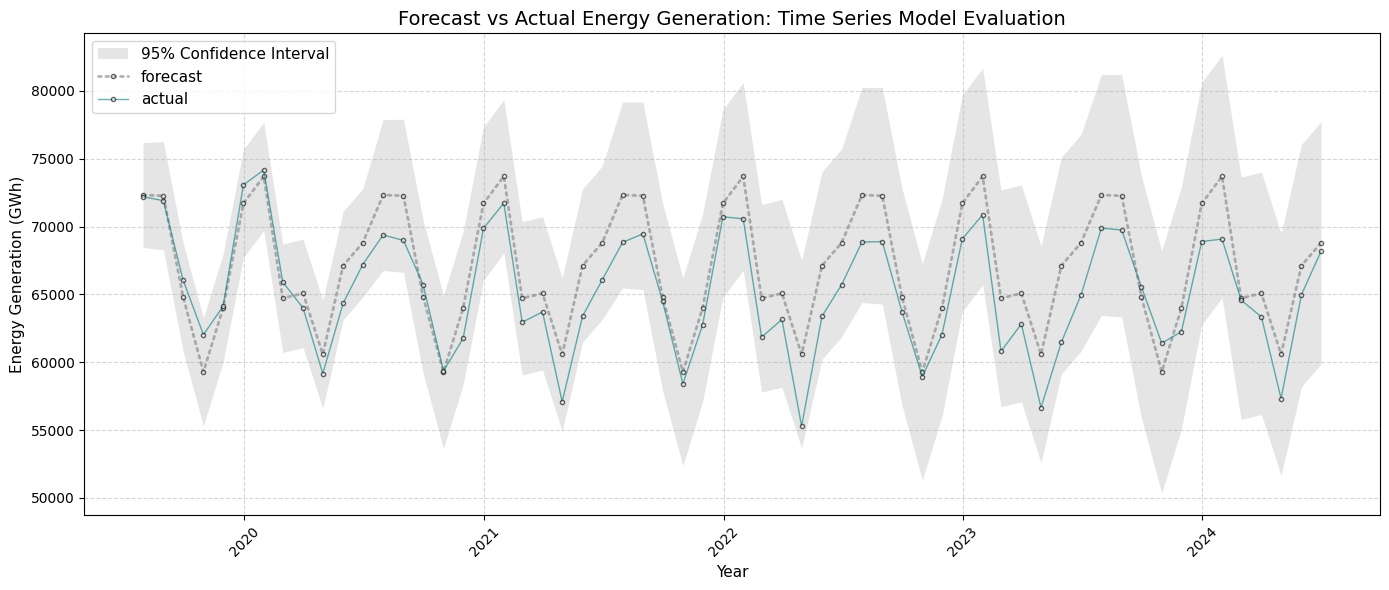

In [156]:
fig, ax = plt.subplots(figsize=(14, 6))

plt.fill_between(
    forecast_ci.index,
    forecast_ci.lower,
    forecast_ci.upper,
    lw=0,
    color="gray",
    alpha=0.2,
    label="95% Confidence Interval"
)


plt.plot(forecast_mean.index, forecast_mean, label="forecast", **pred_options_default )
plt.plot(test.index, test, label="actual",  **line_options_default)

style_ax(ax,
         title="Forecast vs Actual Energy Generation: Time Series Model Evaluation",
         xlabel="Year",
         ylabel="Energy Generation (GWh)",
         )


plt.tight_layout()
plt.show()


Observation:
  - The actual values fall almost entirely within the confidence interval of the predictions.
  
Here's the MAPE of the predictions.

In [157]:
MAPE(forecast_mean, test)

np.float64(3.3817549248044547)

The predictions are off by 3.38% on average, somewhat better than the results we got from seasonal decomposition (3.81%).

MAPE - Mean Absolute Percentage Error:

  - MAPE is a commonly used metric to evaluate forecast accuracy.
  - It expresses prediction error as a percentage of the actual values.


$$
\text{MAPE} = \frac{1}{n} \sum_{t=1}^n \left| \frac{A_t - F_t}{A_t} \right| \times 100
$$

* $A_t$: Actual value at time $t$
* $F_t$: Forecasted value at time $t$
* $n$: Number of observations



Eg. MAPE = 5.2%
  -  the model is off by \~5.2% on average

Note:
  1. We’ll get large or undefined values when actuals are close to 0 - See the denominator in the formula.
  2. Better for *business and energy forecasting* where interpretability matters.


ARIMA is more versatile than seasonal decomposition, and can often make better predictions.

In this time series, the autocorrelations are not especially strong, so the advantage of ARIMA is modest.